# Set Up

## Colab Installation

Run the following code block if you are using this Jupyter notebook in Google Colab. Otherwise skip to importing the packages.

In [ ]:
# Run these statements if you are using Google Colab. Otherwise skip this step.
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!sudo apt install cm-super
!pip install git+https://github.com/QMCSoftware/QMCSoftware.git@SURE2024

## Importing Packages

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
from copy import deepcopy
import sympy as sy
import sympy.stats
# figpath = '' #this path sends the figures to the directory that you want
# savefigs = True  #save the figures on your disk if True
# imgfrmt = 'pdf' #kind of format to save figures as

# Definitions of Python Functions

The following functions are things that will be repeatedly used in the notebook so that there isn't duplicate code all over the place.

## Graphing Functions

The following functions are to help with graphing.

In [3]:
def make_grid(d=3, nper=2):
    """this function creates a nper^d x d matrix of grid points"""
    xpts = np.linspace(1/(2*nper), 1.0-1/(2*nper), nper)  # array of coordinate values
    xgrid = xpts  # initial grid
    n = nper  # initial length of grid
    for ii in range(1,d):
        xgrid0 = xgrid  # store the old grid
        xgrid = np.vstack((xgrid0, xpts[0] * np.ones((1, n))))  # stack the next coordinate
        for jj in range(1, nper):
            xgrid = np.hstack((xgrid, np.vstack((xgrid0, xpts[jj] * np.ones((1, n))))))
        n = n * nper  # update the length of the grid
    return xgrid.T  # take the transpose to that coordinates are columns

def plot_grid(xgrid, coord_to_plot=[0, 1], savefig=True, figpath=''):
    """Plots a dot grid."""
    n = xgrid.shape[0]
    d = xgrid.shape[1]
    coord_to_plot = np.minimum(coord_to_plot, [d, d]), # ensure that they are no more than d
    coord_to_plot = coord_to_plot[0]
    coord_to_plot = np.maximum(coord_to_plot, [1, 1]), # ensure that they are no less than 1
    coord_to_plot = coord_to_plot[0]
    fig, ax = plt.subplots()
    ax.plot(xgrid[:,coord_to_plot[0]-1], xgrid[:,coord_to_plot[1]-1], 'b.', markersize = 10, zorder=10, clip_on=False)
    ax.set_title(f"{n:.0f} Grid Points for $d = ${d:.0f}")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel(r'$x_{i%d}$'%(coord_to_plot[0]), fontsize=14)
    ax.set_ylabel(r'$x_{i%d}$'%(coord_to_plot[1]), fontsize=14)
    ax.set_aspect(1)
    if savefigs:
        fig.savefig(figpath + f"{n:.0f}gridpts_d{d:.0f}." + imgfrmt, format=imgfrmt)


In [12]:
def graph_kernel(bandwidths, lin_spaces, kernel, ylim_lst=[-0.05, 1.2]):
  """Graphs a given kernel, with given bandwidths, lin_spaces
  bandwidths = a list of bandwidths
  lin_spaces = a list of 3 integers: start, finish, and number of points"""
  ypts = np.linspace(lin_spaces[0], lin_spaces[1], lin_spaces[2])
  nband = len(bandwidths)
  fig, ax = plt.subplots(1, 3, figsize=(5*nband, 5))
  for ii in range(nband):
      ax[ii].plot(ypts,kernel(ypts/bandwidths[ii]) / bandwidths[ii])
      ax[ii].grid(False)
      ax[ii].set_ylim(ylim_lst)
      ax[ii].set_xlabel(r'$y$', fontsize=20)
      ax[ii].set_ylabel(r'$h = {%0.1f}$'%bandwidths[ii], fontsize=20)
    #   if (ii == 0):
    #       ax[ii].set_ylabel(r'$\widetilde{k}(y) = \exp(-(y/h)^2)/(\sqrt{\pi}h), \ h = {%0.1f}$'%bandwidths[ii], fontsize=20)
    #   else:
    #       ax[ii].set_ylabel(r'$h = {%0.1f}$'%bandwidths[ii], fontsize=20)

In [5]:
def generate_sobol_iid_graph(bandwidths, lin_spaces, kde, kernel, yiid, ysob, ylim_lst=[-0.05, 1.2]):
  """Generates a graph using IID and Sobol sample points.
  bandwidths = a list of bandwidths
  lin_spaces = a list of 3 integers: start, finish, and number of points
  kde = name of kde function
  kernel = name of kernel function
  yiid = set of iid points
  ysob = set of LD points generated with sobol sequence"""
  nband = len(bandwidths)
  yeval = np.linspace(lin_spaces[0], lin_spaces[1], lin_spaces[2])
  for ii in range(nband):
      rhovaliid = kde(kernel, yiid, bandwidths[ii], yeval)
      rhovalsob = kde(kernel, ysob, bandwidths[ii], yeval)
      fig,ax = plt.subplots()
      ax.plot(yeval, rhovaliid, label = "IID")
      ax.plot(yeval, rhovalsob, label = "Sobol")
      ax.legend()
      ax.set_ylim(ylim_lst)
      ax.set_title(f"$h = {bandwidths[ii]:.2f}$")

In [6]:
def generate_graphs(bandwidths, lin_spaces, kde, kernel, sample_points, ylim_lst=[-0.05, 1.2]):
  """
  Generate graphs involving a kde, kernel, and sample_points.
  sample_points is a list of IID, Sobol, Lattice, DNB2, and Halton points.
  """
  nband = len(bandwidths)
  yeval = np.linspace(lin_spaces[0], lin_spaces[1], lin_spaces[2])
  rho_list = list()
  for ii in range(nband):
      rhovaliid = kde(kernel, sample_points[0], bandwidths[ii], yeval)
      rhovalsob = kde(kernel, sample_points[1], bandwidths[ii], yeval)
      rhovallattice = kde(kernel, sample_points[2], bandwidths[ii], yeval)
      rhovaldnetb2 = kde(kernel, sample_points[3], bandwidths[ii], yeval)
      rhovalhalton = kde(kernel, sample_points[4], bandwidths[ii], yeval)
      fig, ax = plt.subplots()
      ax.plot(yeval, rhovaliid, label = "IID")
      ax.plot(yeval, rhovalsob, label = "Sobol")
      ax.plot(yeval, rhovallattice, label = "Lattice")
      ax.plot(yeval, rhovaldnetb2, label = "Digital Net B2")
      ax.plot(yeval, rhovalhalton, label = "Halton")
      ax.legend()
      ax.set_ylim(ylim_lst)
      ax.set_title(f"$h = {bandwidths[ii]:.2f}$")

## Generate Functions

The following functions are used to generate different types of sample points.

In [7]:
def gen_iid_and_sobol(dimen = 3, n = 2**12):
  """Generate IID and Sobol sample points based on given sample size and dimensions."""
  coord_wts = 2.0 ** (-np.array(range(0, dimen)))
  iidpts = qp.IIDStdUniform(dimen).gen_samples(n)
  sobpts = qp.Sobol(dimen).gen_samples(n)
  return (iidpts, sobpts)

def gen_iid_ld_pts(dimen = 3, n = 2**12):
  """
  Generate IID, Sobol, Lattic, DNB2, and Halton sample points,
  based on dimension and smaple size.
  """
  coord_wts = 2.0**(-np.array(range(0, dimen)))
  iidpts = qp.IIDStdUniform(dimen).gen_samples(n)
  sobpts = qp.Sobol(dimen).gen_samples(n)
  latticepts = qp.Lattice(dimen).gen_samples(n)
  dnetb2pts = qp.DigitalNetB2(dimen).gen_samples(n)
  haltonpts = qp.Halton(dimen).gen_samples(n)
  return (iidpts, sobpts, latticepts, dnetb2pts, haltonpts)

## Generating Points

Generating sequences of IID and LD points, with dimensions 1 and 3.

In [18]:
# dim = 1, n = 2**12
iidpts1, sobpts1, latticepts1, dnetb2pts1, haltonpts1 = gen_iid_ld_pts(dimen = 1, n = 2**12)
# print("iid: ", iidpts1)
# print("sobol: ", sobpts1)
# print("lattice: ", latticepts1)
# print("digital net B2: ", dnetb2pts1)
# print("halton: ", haltonpts1)

In [24]:
# dim = 1, n = 2**10
few_iidpts1, few_sobpts1, few_latticepts1, few_dnetb2pts1, few_haltonpts1 = gen_iid_ld_pts(dimen = 1, n = 2**10)
# print("iid: ", few_iidpts1)
# print("sobol: ", few_sobpts1)
# print("lattice: ", few_latticepts1)
# print("digital net B2: ", few_dnetb2pts1)
# print("halton: ", few_haltonpts1)

In [21]:
# dim = 1, n = 2**14
many_iidpts1, many_sobpts1, many_latticepts1, many_dnetb2pts1, many_haltonpts1 = gen_iid_ld_pts(dimen = 1, n = 2**14)
# print("iid: ", many_iidpts1)
# print("sobol: ", many_sobpts1)
# print("lattice: ", many_latticepts1)
# print("digital net B2: ", many_dnetb2pts1)
# print("halton: ", many_haltonpts1)

In [23]:
# dim = 3, n = 2**12
iidpts3, sobpts3, latticepts3, dnetb2pts3, haltonpts3 = gen_iid_ld_pts(dimen = 3, n = 2**12)
# print("iid: ", iidpts3)
# print("sobol: ", sobpts3)
# print("lattice: ", latticepts3)
# print("digital net B2: ", dnetb2pts3)
# print("halton: ", haltonpts3)

In [26]:
# dim = 3, n = 2**10
few_iidpts3, few_sobpts3, few_latticepts3, few_dnetb2pts3, few_haltonpts3 = gen_iid_ld_pts(dimen = 3, n = 2**10)
# print("iid: ", few_iidpts3)
# print("sobol: ", few_sobpts3)
# print("lattice: ", few_latticepts3)
# print("digital net B2: ", few_dnetb2pts3)
# print("halton: ", few_haltonpts3)

In [28]:
# dim = 3, n = 2**14
many_iidpts3, many_sobpts3, many_latticepts3, many_dnetb2pts3, many_haltonpts3 = gen_iid_ld_pts(dimen = 3, n = 2**14)
# print("iid: ", many_iidpts3)
# print("sobol: ", many_sobpts3)
# print("lattice: ", many_latticepts3)
# print("digital net B2: ", many_dnetb2pts3)
# print("halton: ", many_haltonpts3)

## Kernels and KDEs

The following are definitions of different kernels used in the notebook. Some may be defined later, but these are ones used throughout the notebook or commonly used/known.

The gaussian kernel defined below represents the following:

$$
\frac{e^{-y^2}}{\sqrt{\pi}}
$$

In [8]:
def kernel(y):
    return np.exp(-y * y) / np.sqrt(np.pi)

# Graphing, Testing, and Other Stuff

The following graphs the gaussian kernel.

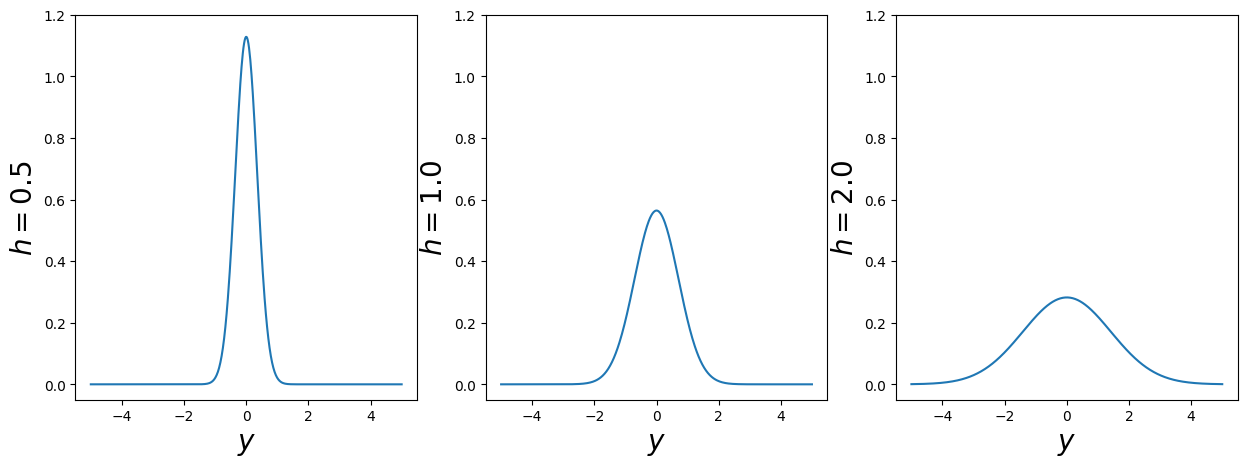

In [13]:
spaces = (-5, 5, 500)
bw = [0.5, 1, 2]
graph_kernel(bw, spaces, kernel)

#### Generate some $y_i=f(x_i)$ points
$
f(\mathbf{x}) = 10 \exp(- w_1x_1 - \cdots - w_d x_d) \sin(w_1x_1 + \cdots +w_d x_d)
$

In [29]:
def testfun1(x, coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x, coord_wts)
    y = 10 * np.exp(-wtx.sum(1)) * np.sin(np.pi * wtx.sum(1))
    #y = x[:,0] # if x is uniform, then y is uniform
    return y

In [30]:
yiid1 = testfun1(iidpts1)
ysob1 = testfun1(sobpts1)

yiid3 = testfun1(iidpts3)
ysob3 = testfun1(sobpts3)

In [31]:
many_yiid1 = testfun1(many_iidpts1)
many_ysob1 = testfun1(many_sobpts1)

many_yiid3 = testfun1(many_iidpts3)
many_ysob3 = testfun1(many_sobpts3)

In [32]:
few_yiid1 = testfun1(few_iidpts1)
few_ysob1 = testfun1(few_sobpts1)

few_yiid3 = testfun1(few_iidpts3)
few_ysob3 = testfun1(few_sobpts3)

The following *Kernel Density Estimator* (KDE)

$$
\varrho() = \frac{k\left(\frac{y - Y}{h}\right)}{h}
$$

*(Still needs work.)*

In [34]:
def kde(kernel, ypts, bandwidth, yeval):
    neval = len(yeval)
    rhoval = np.zeros_like(yeval) #values of density estimator
    for ii in range(len(yeval)):
        rhoval[ii] = np.mean(kernel((yeval[ii]-ypts) / bandwidth)) / bandwidth
    return rhoval

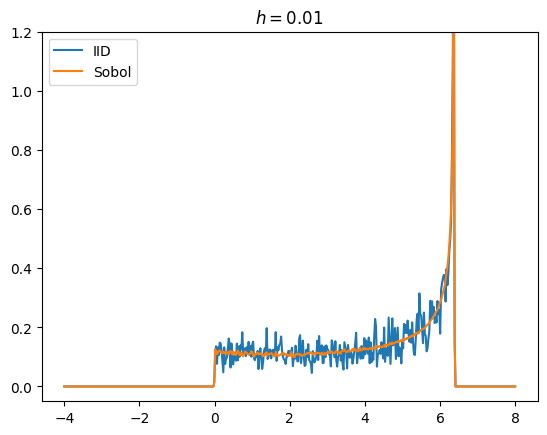

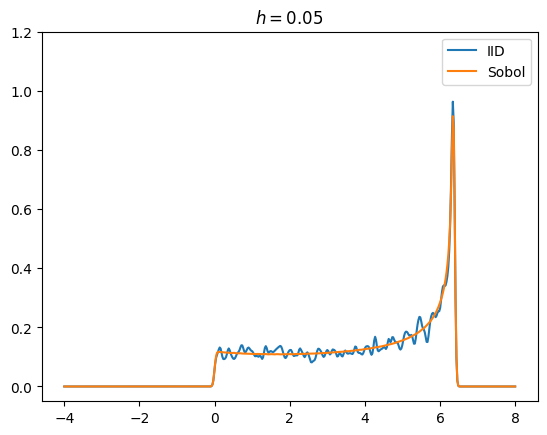

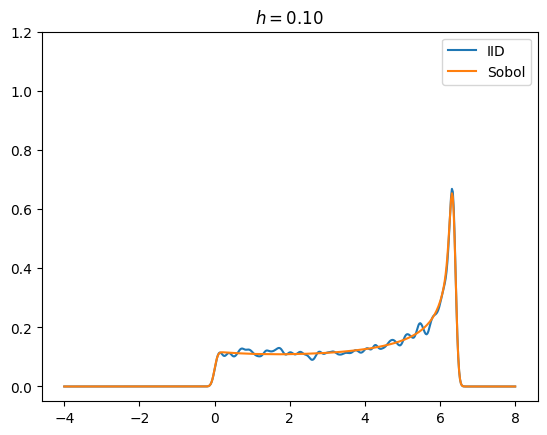

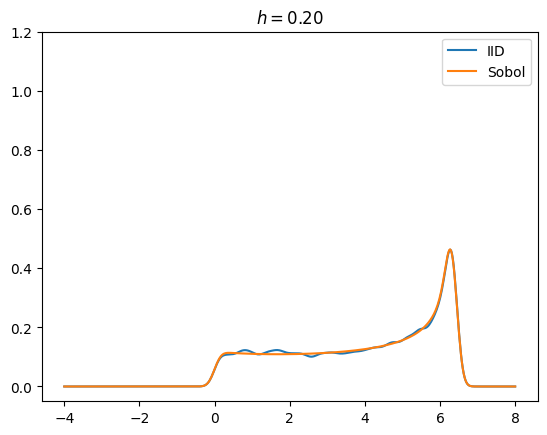

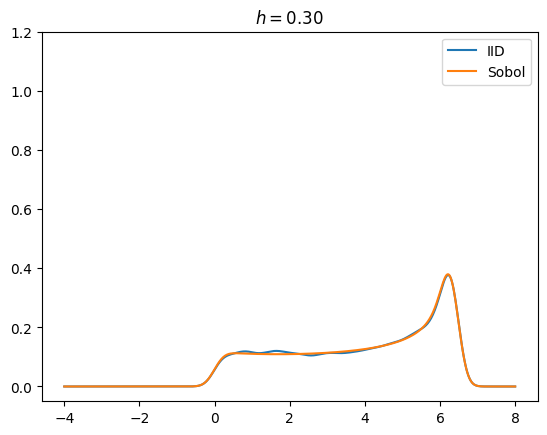

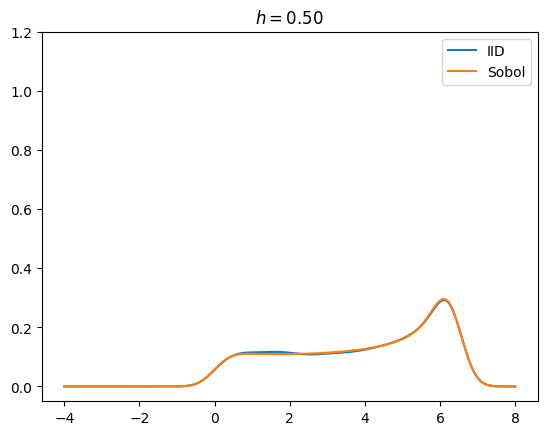

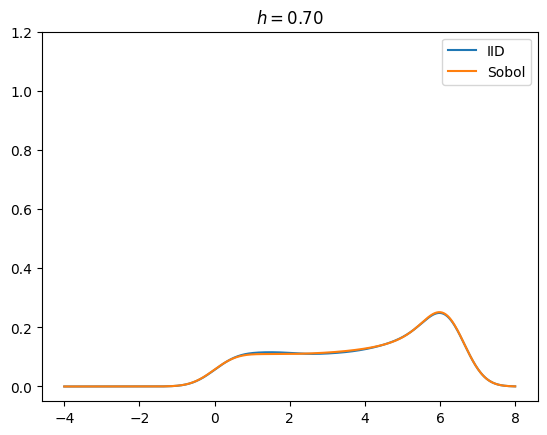

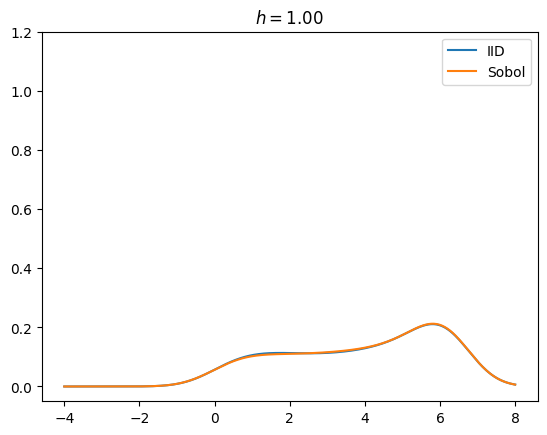

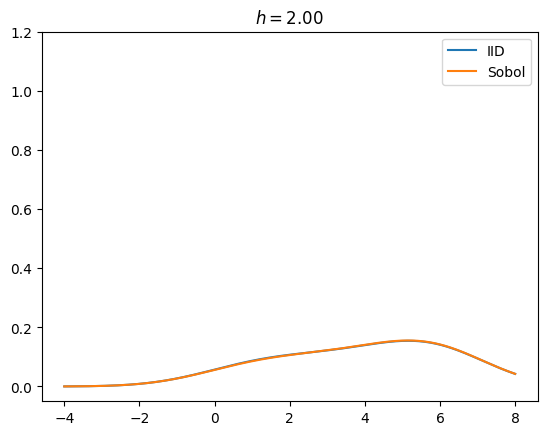

In [35]:
# dim = 1, n = 2**12
bw = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
spaces = (-4, 8, 500)
generate_sobol_iid_graph(bw, spaces, kde, kernel, yiid1, ysob1)

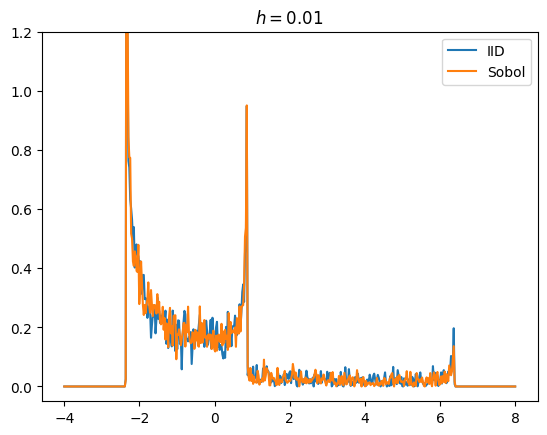

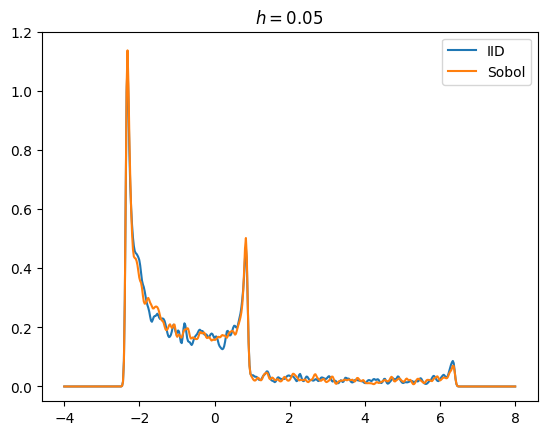

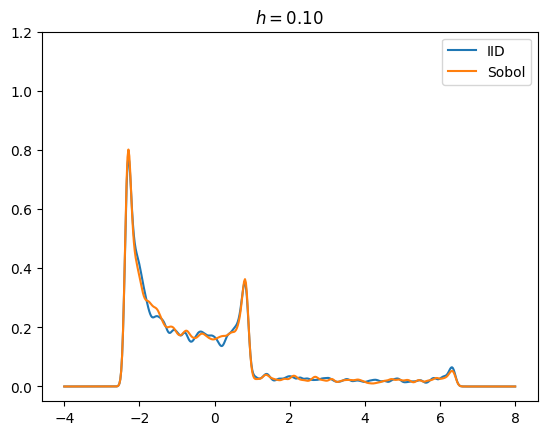

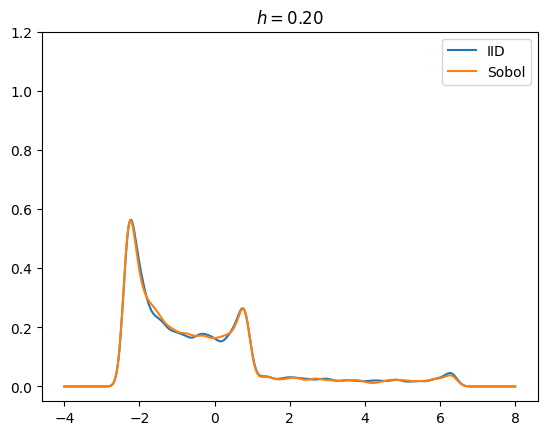

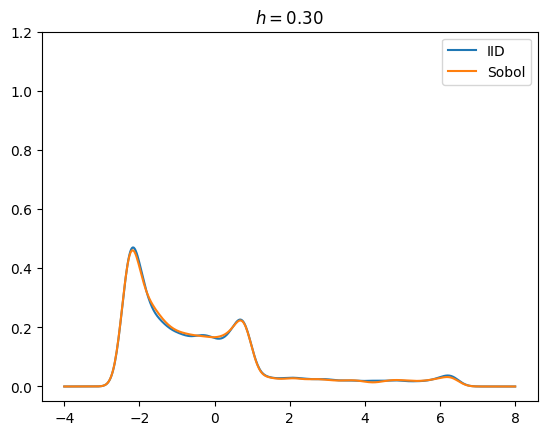

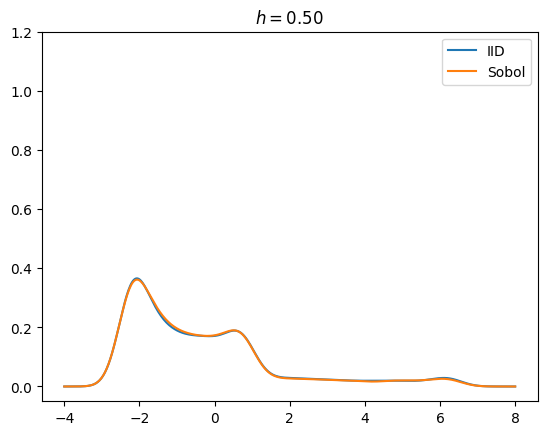

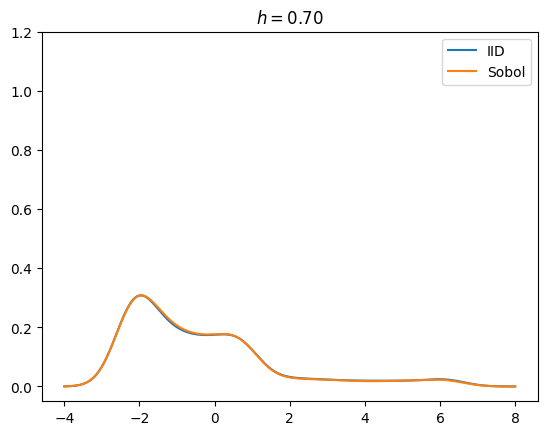

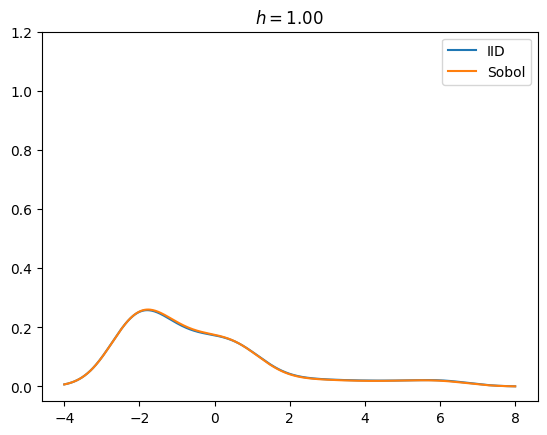

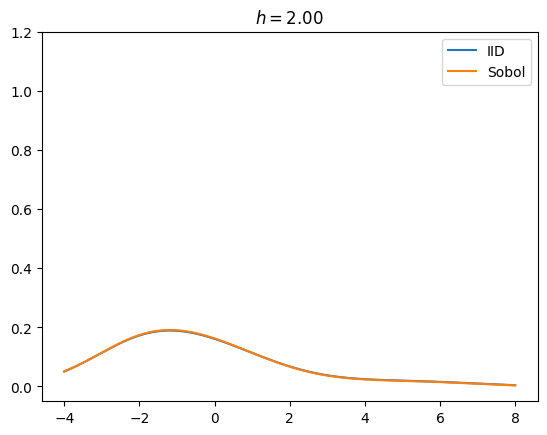

In [36]:
# dim = 3, n = 2**12
bw = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
spaces = (-4, 8, 500)
generate_sobol_iid_graph(bw, spaces, kde, kernel, yiid3, ysob3)

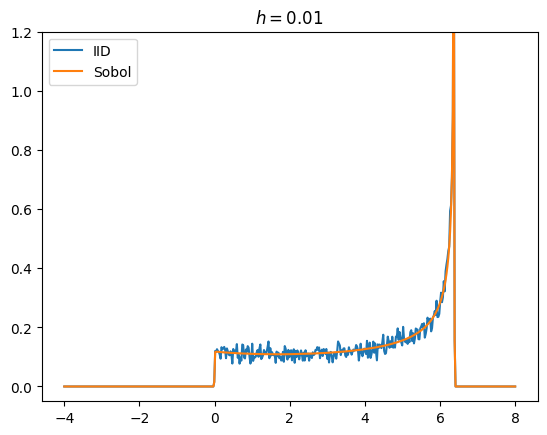

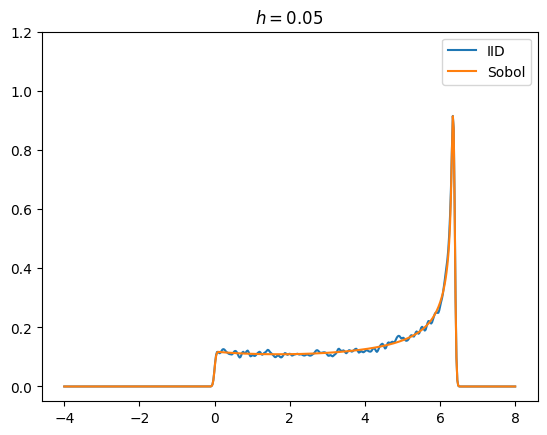

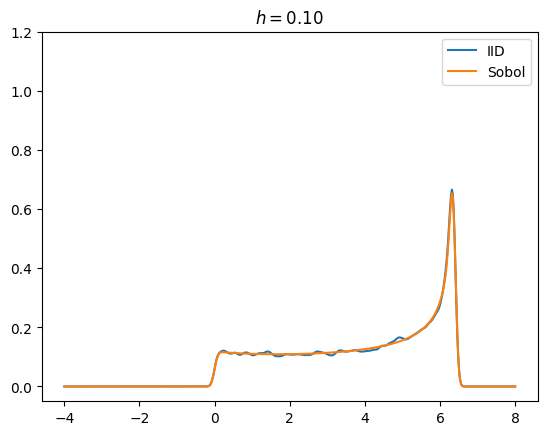

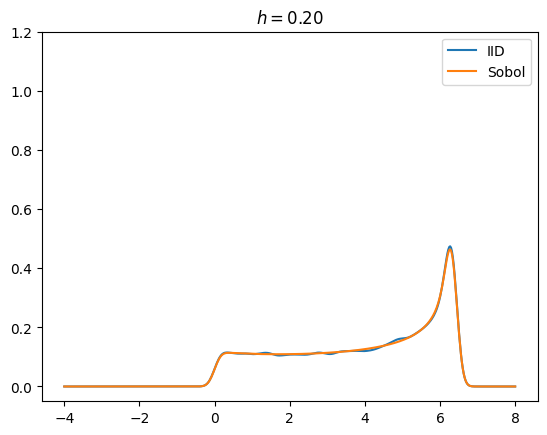

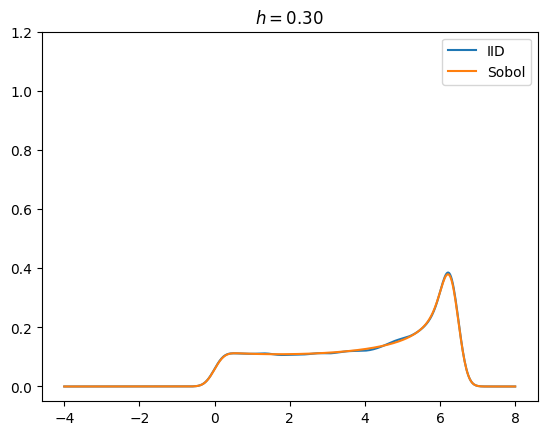

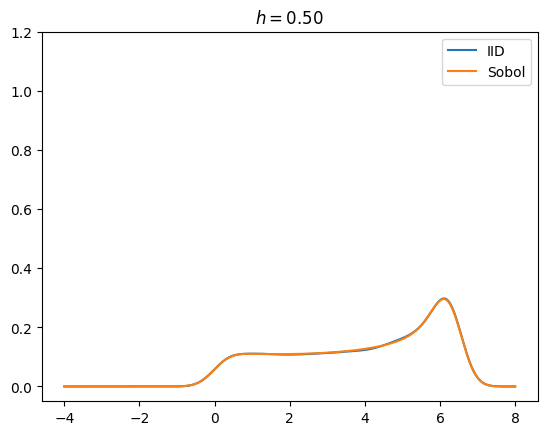

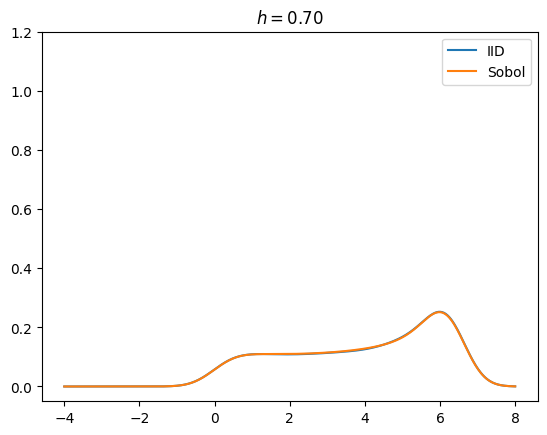

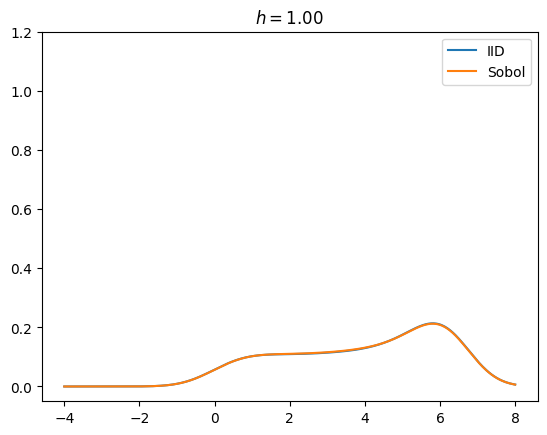

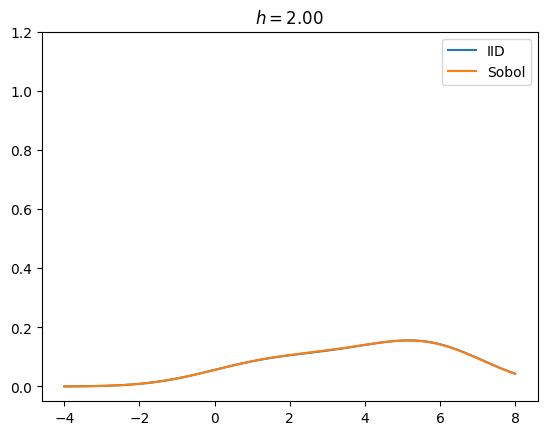

In [37]:
# dim = 1, many points n = 2**14
bw = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
spaces = (-4, 8, 500)
generate_sobol_iid_graph(bw, spaces, kde, kernel, many_yiid1, many_ysob1)

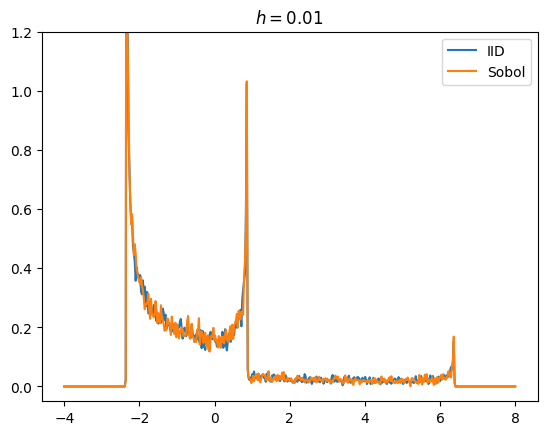

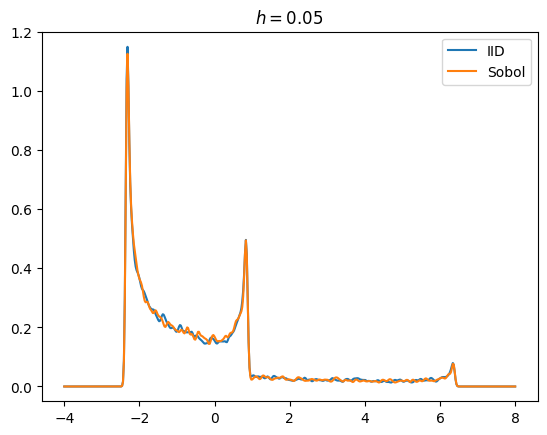

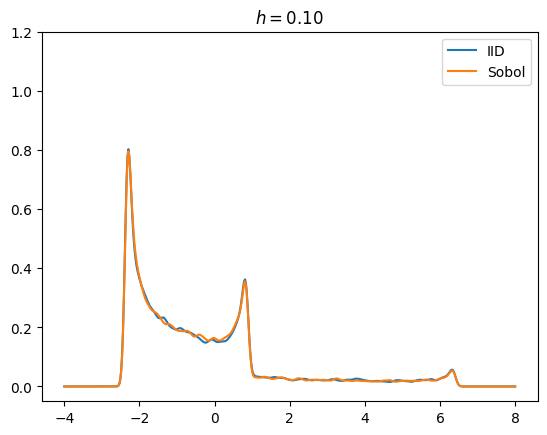

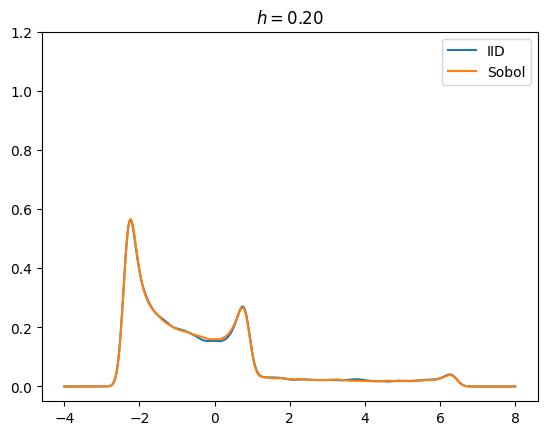

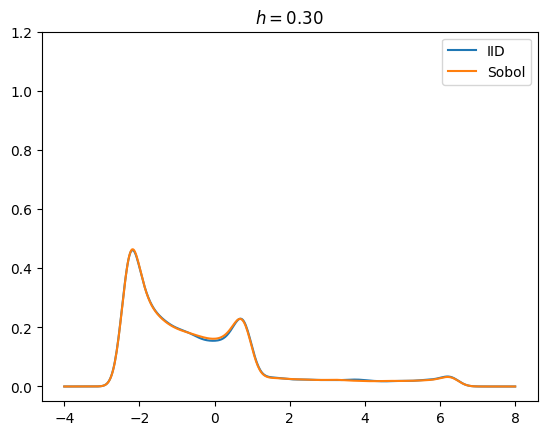

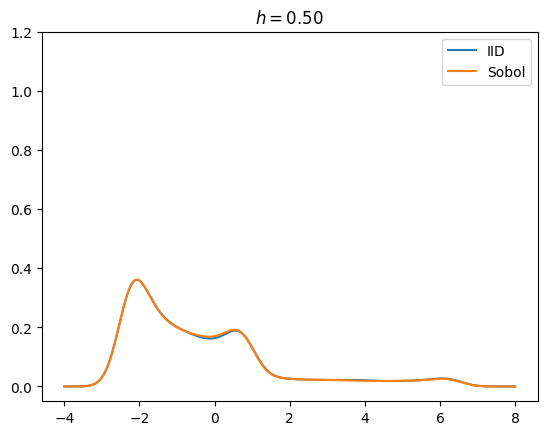

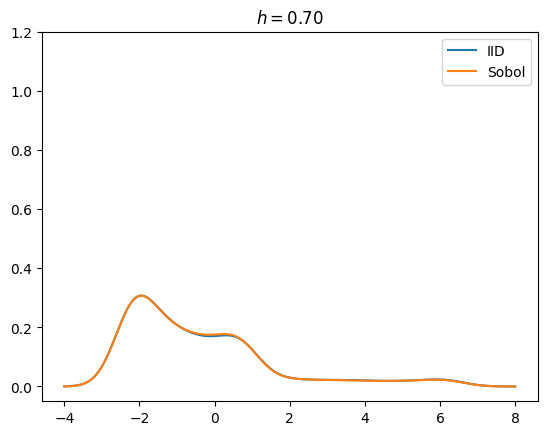

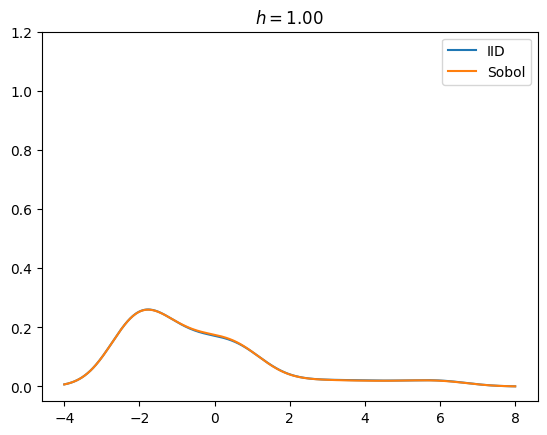

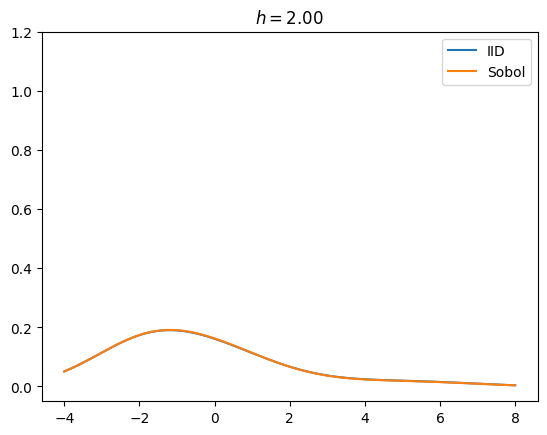

In [38]:
# dim = 3, many points n = 2**14
bw = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
spaces = (-4, 8, 500)
generate_sobol_iid_graph(bw, spaces, kde, kernel, many_yiid3, many_ysob3)

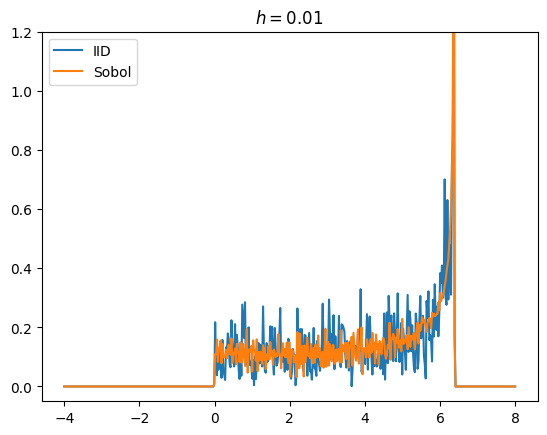

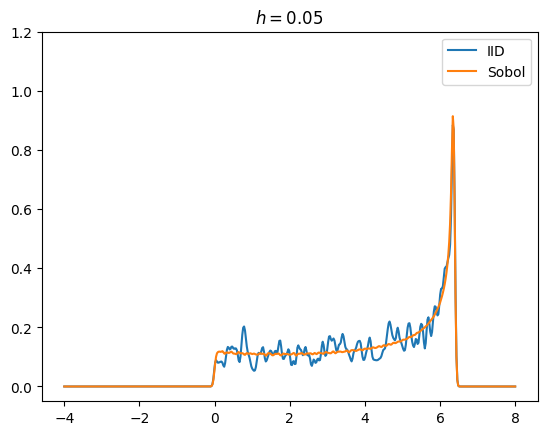

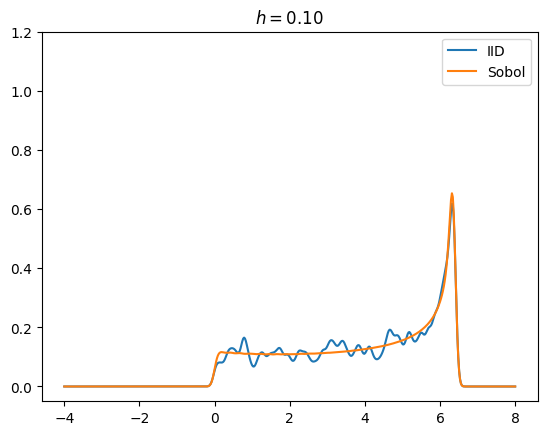

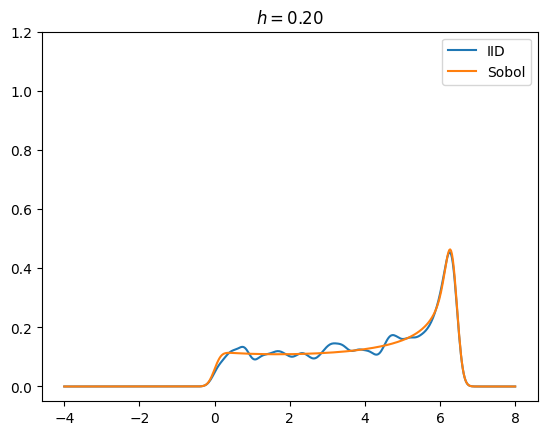

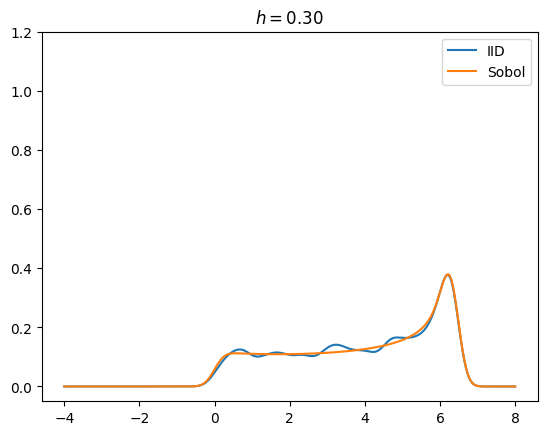

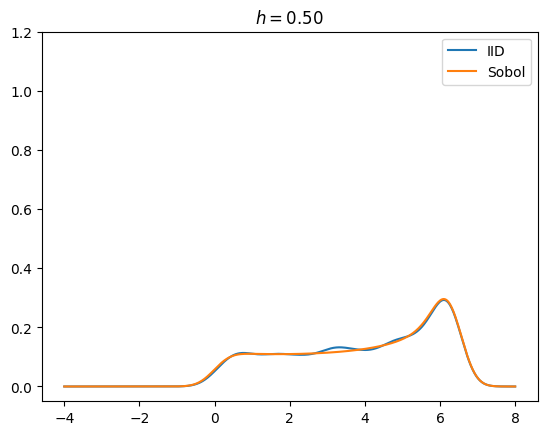

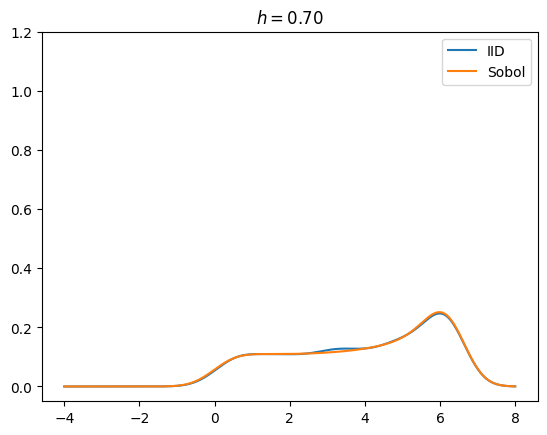

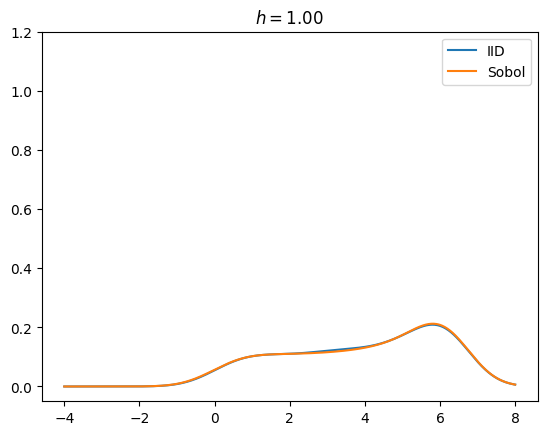

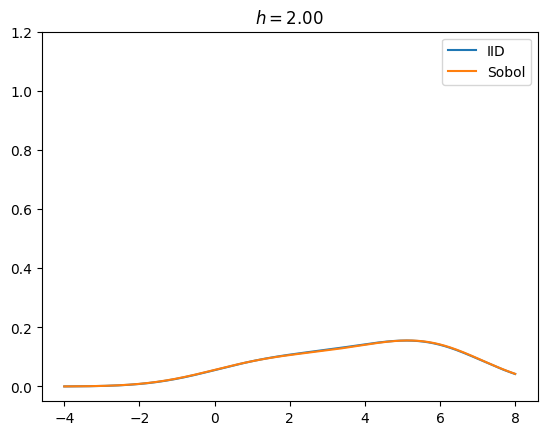

In [40]:
# dim = 1, fewer points n = 2**10
bw = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
spaces = (-4, 8, 500)
generate_sobol_iid_graph(bw, spaces, kde, kernel, few_yiid1, few_ysob1)

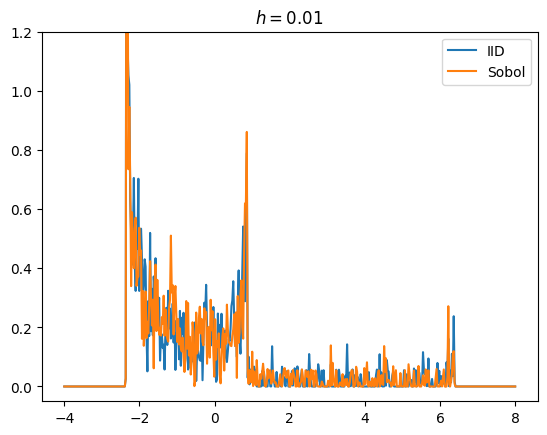

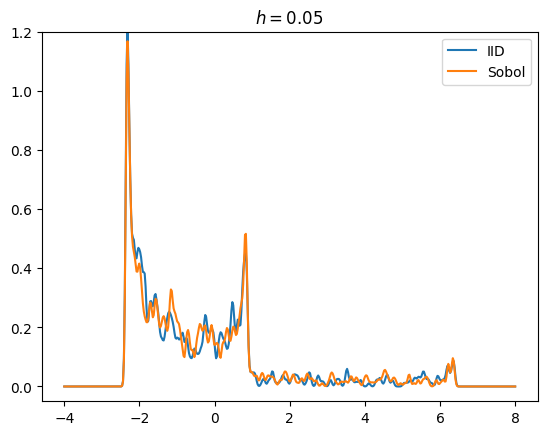

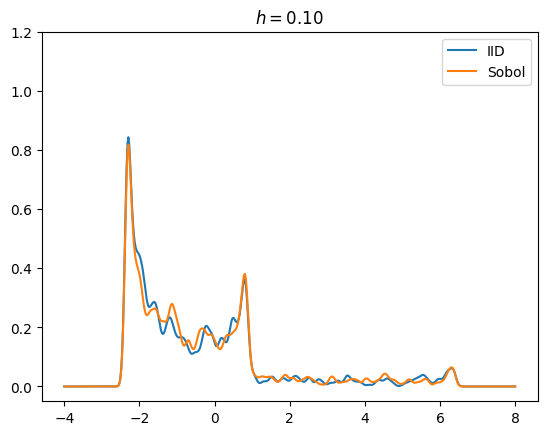

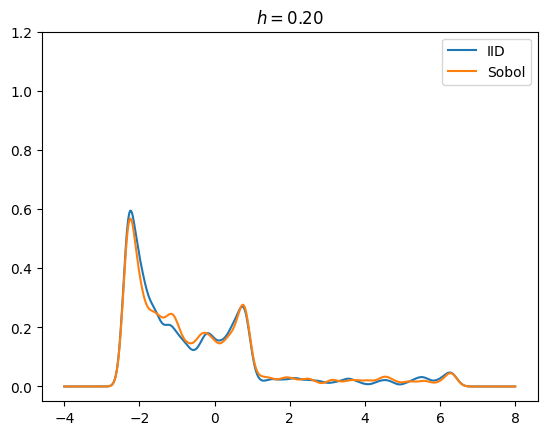

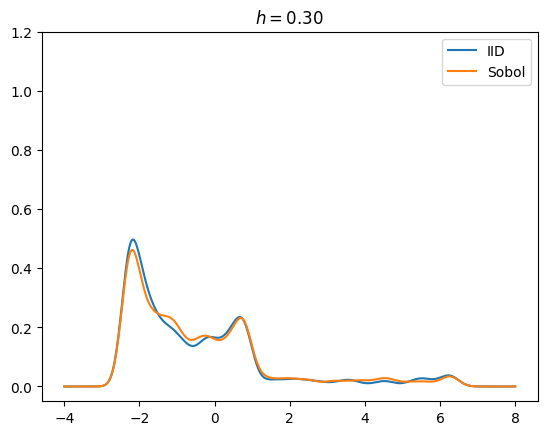

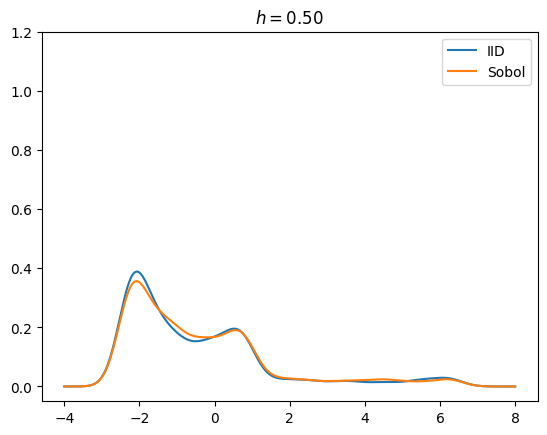

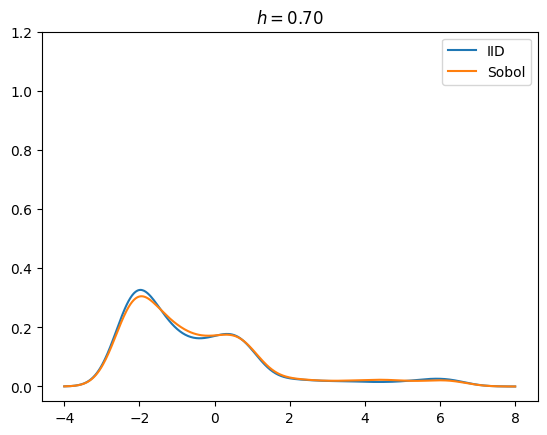

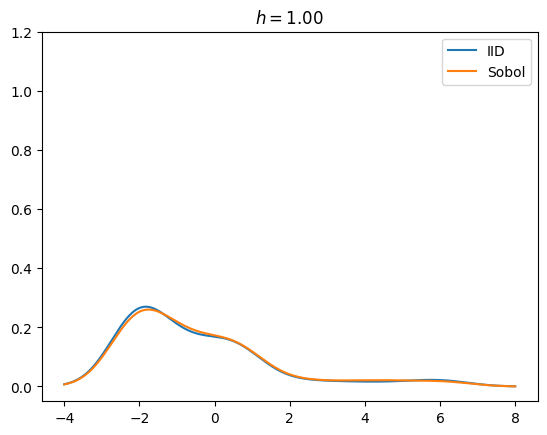

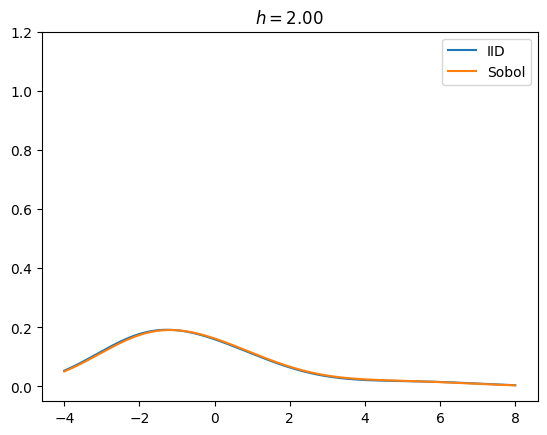

In [41]:
# dim = 3, fewer points n = 2**10
bw = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
spaces = (-4, 8, 500)
generate_sobol_iid_graph(bw, spaces, kde, kernel, few_yiid3, few_ysob3)

# Kernel Density Estimator for Uniform Distribution

In [42]:
def testfun_unif(x, coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x, coord_wts)
    # y = 10*np.exp(-wtx.sum(1))*np.sin(np.pi*wtx.sum(1))
    y = x[:,0] # if x is uniform, then y is uniform
    return y

In [43]:
yiid_unif1 = testfun_unif(iidpts1)
ysob_unif1 = testfun_unif(sobpts1)

yiid_unif3 = testfun_unif(iidpts3)
ysob_unif3 = testfun_unif(sobpts3)

In [44]:
many_yiid_unif1 = testfun_unif(many_iidpts1)
many_ysob_unif1 = testfun_unif(many_sobpts1)

many_yiid_unif3 = testfun_unif(many_iidpts3)
many_ysob_unif3 = testfun_unif(many_sobpts3)

In [45]:
few_yiid_unif1 = testfun_unif(few_iidpts1)
few_ysob_unif1 = testfun_unif(few_sobpts1)

few_yiid_unif3 = testfun_unif(few_iidpts3)
few_ysob_unif3 = testfun_unif(few_sobpts3)

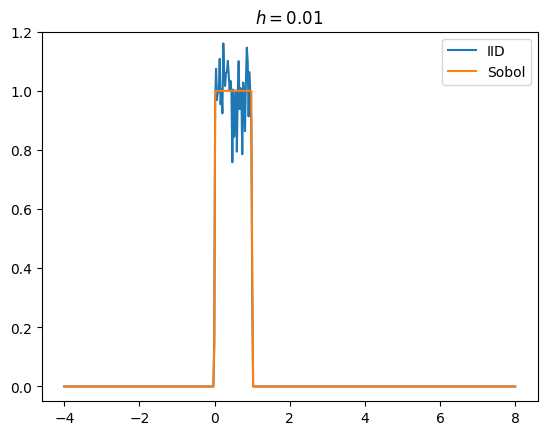

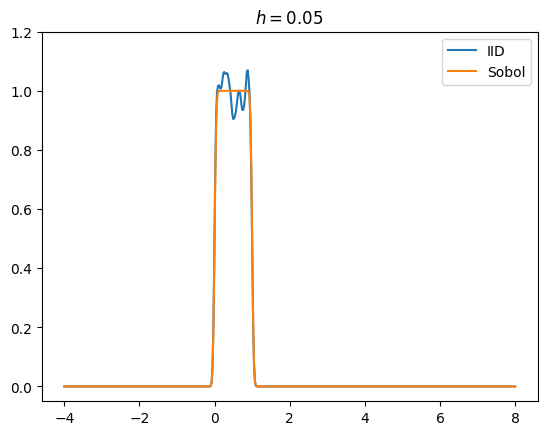

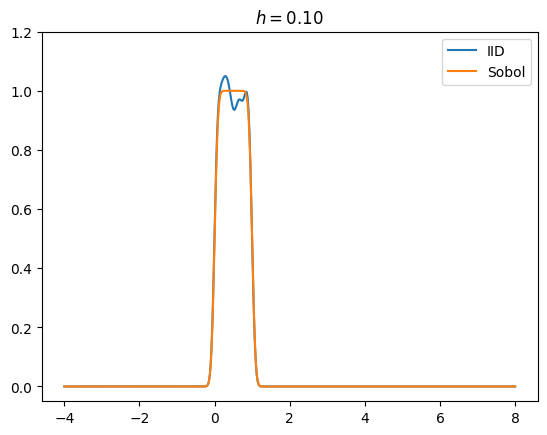

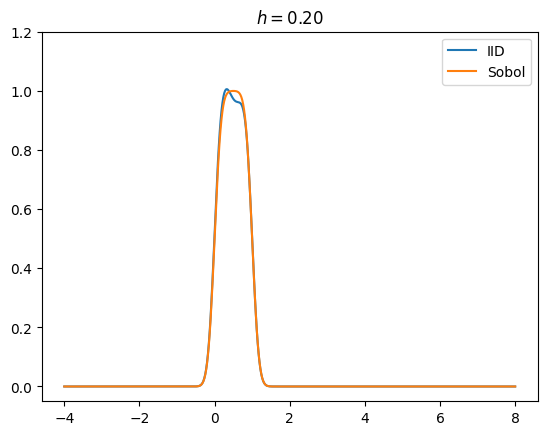

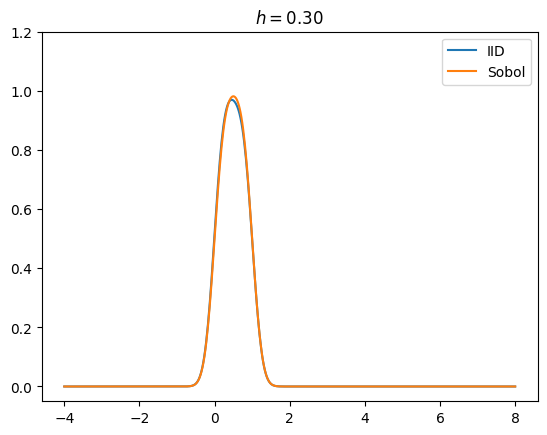

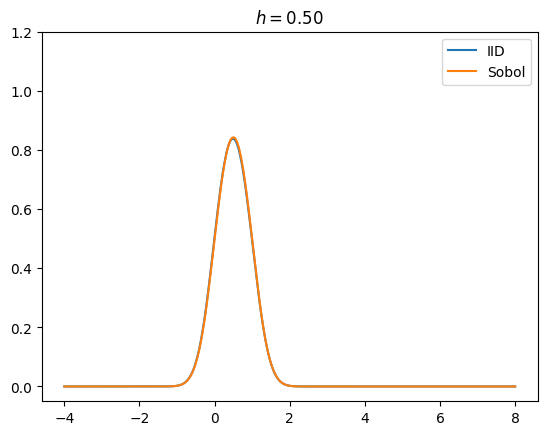

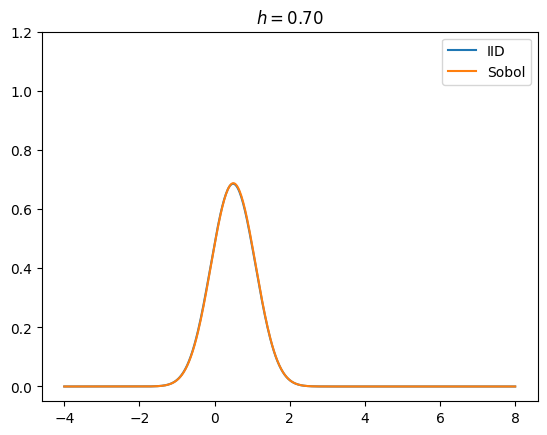

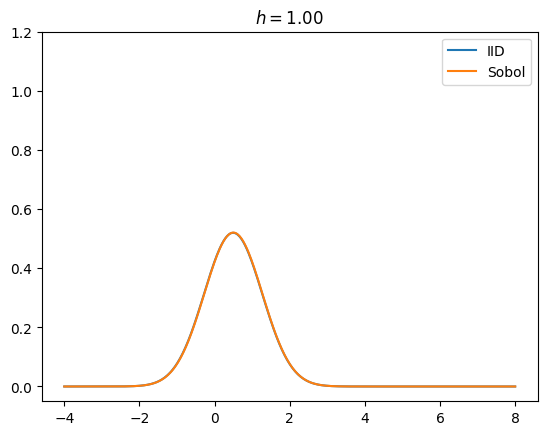

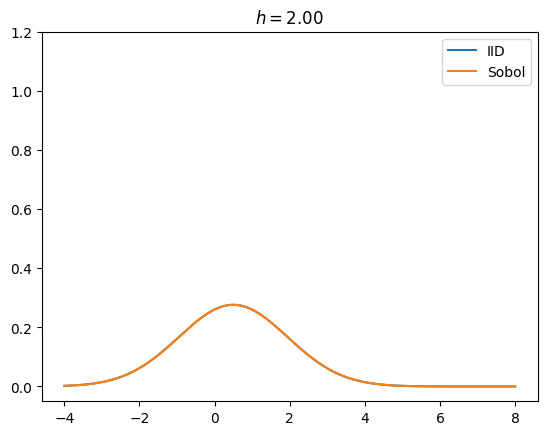

In [46]:
# dim = 1, n = 2**12
bw = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
spaces = (-4, 8, 500)
generate_sobol_iid_graph(bw, spaces, kde, kernel, yiid_unif1, ysob_unif1)

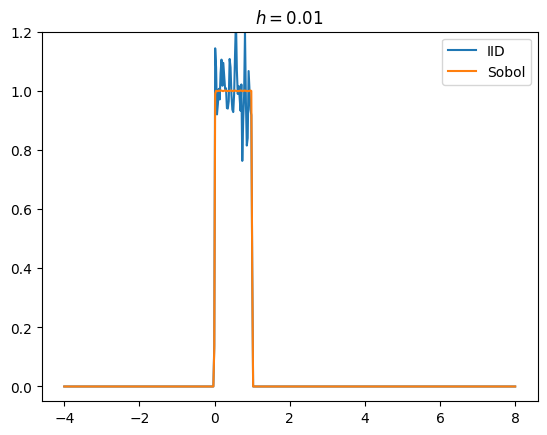

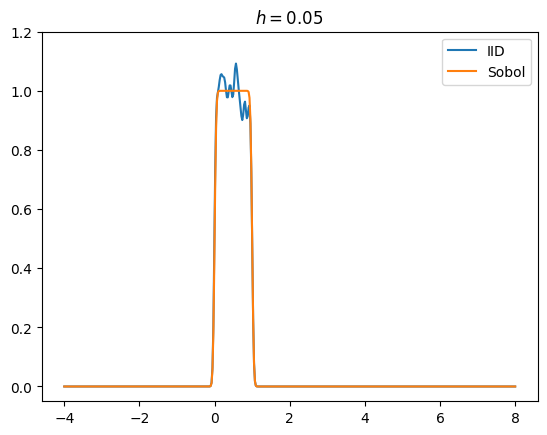

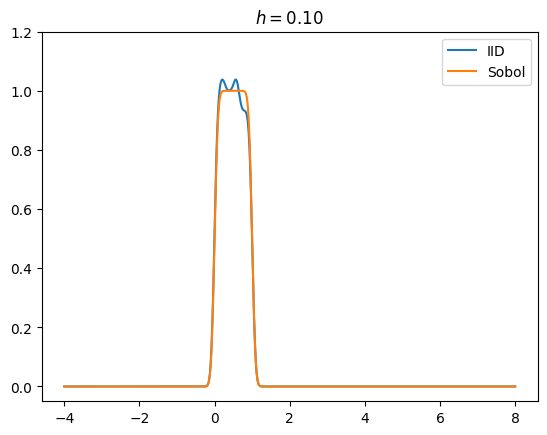

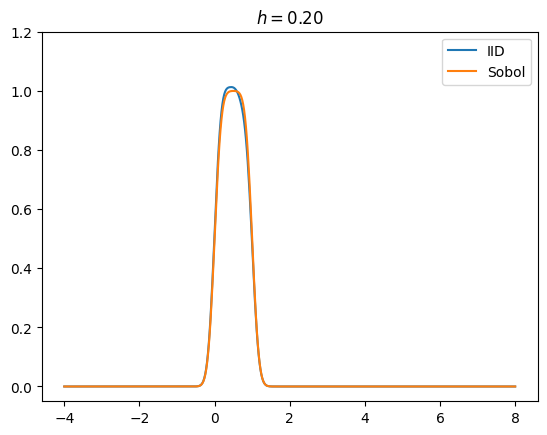

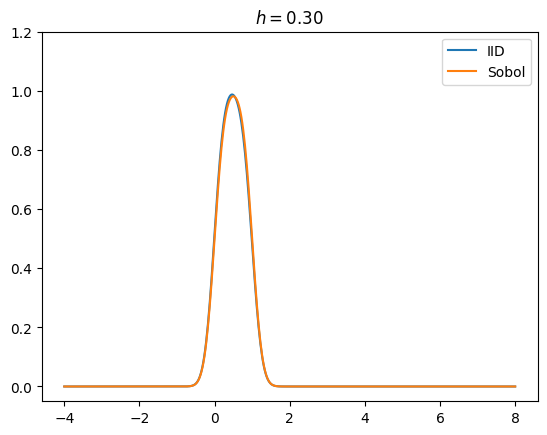

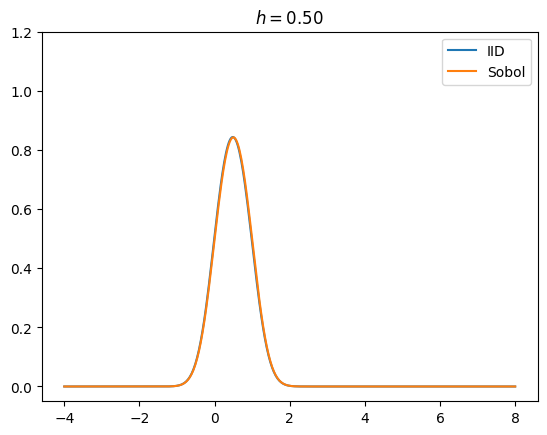

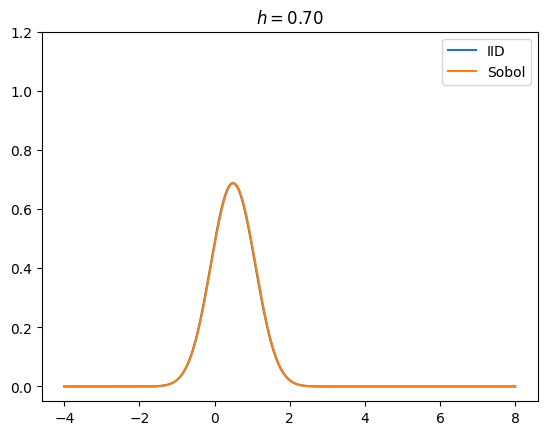

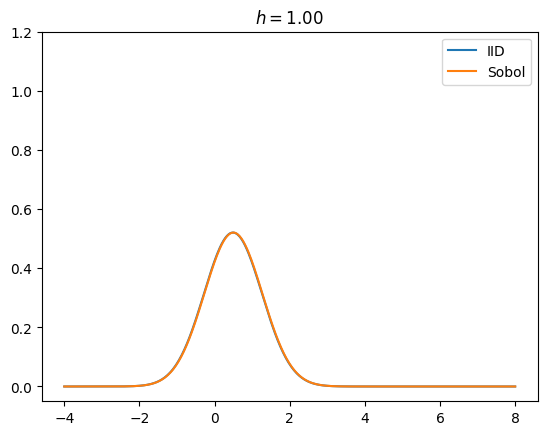

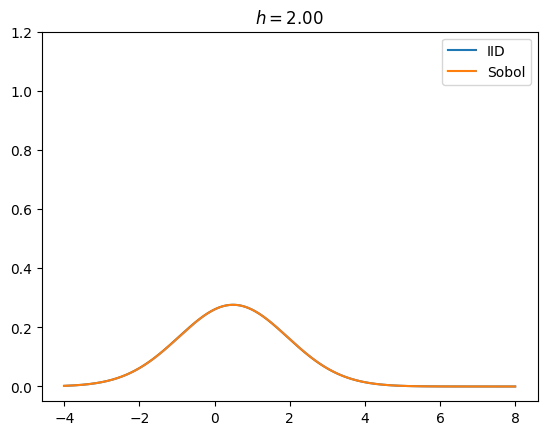

In [47]:
# dim = 3, n = 2**12
bw = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
spaces = (-4, 8, 500)
generate_sobol_iid_graph(bw, spaces, kde, kernel, yiid_unif3, ysob_unif3)

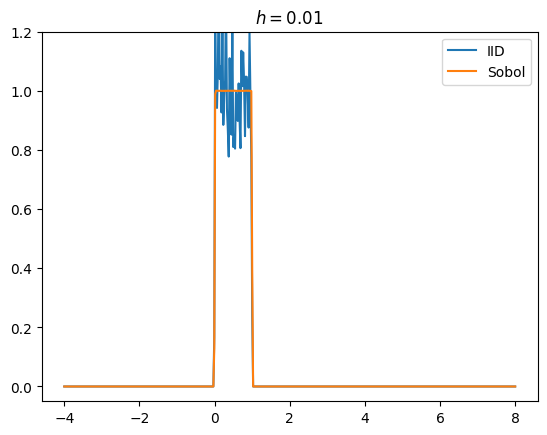

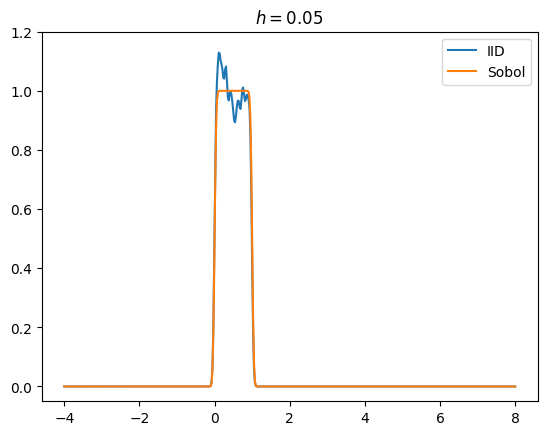

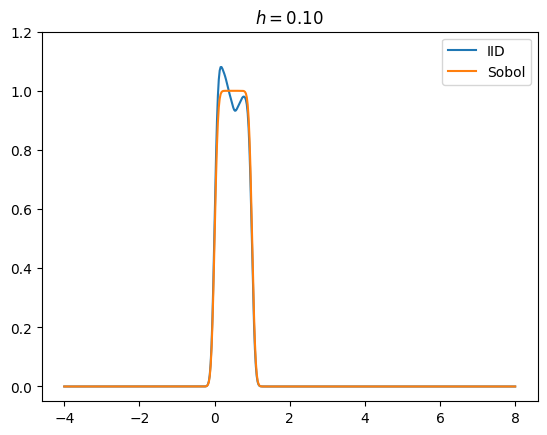

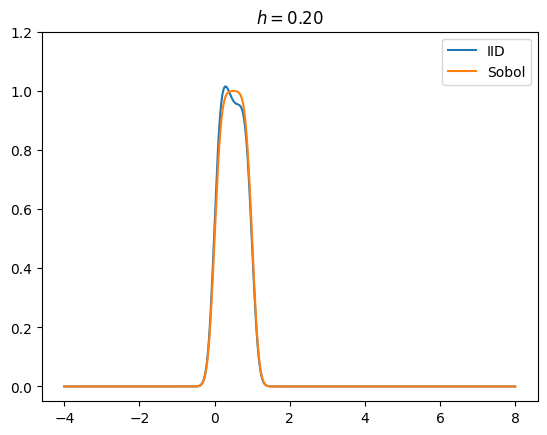

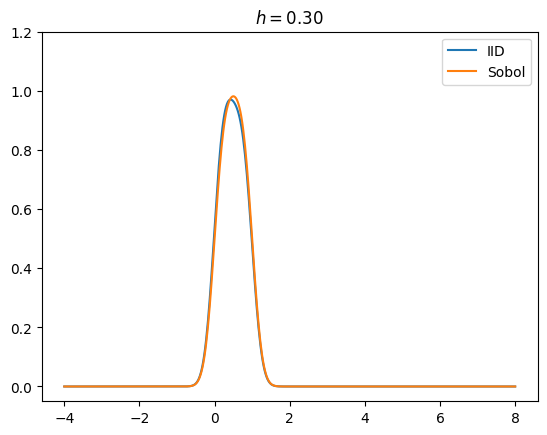

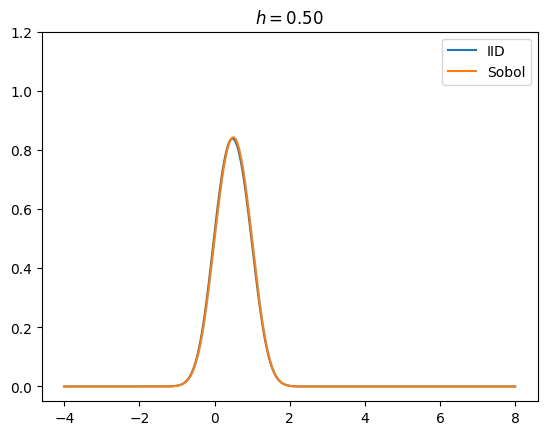

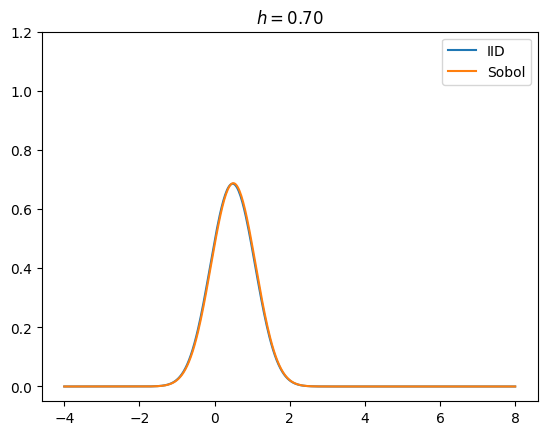

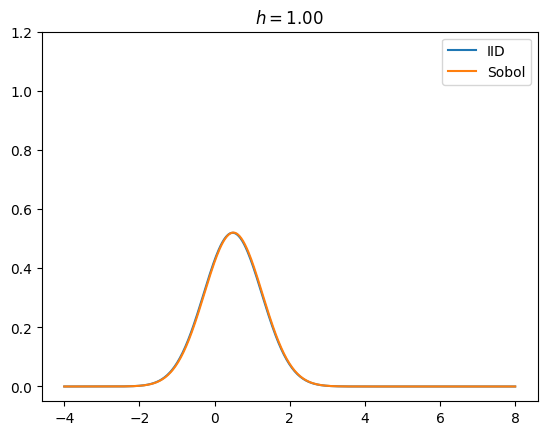

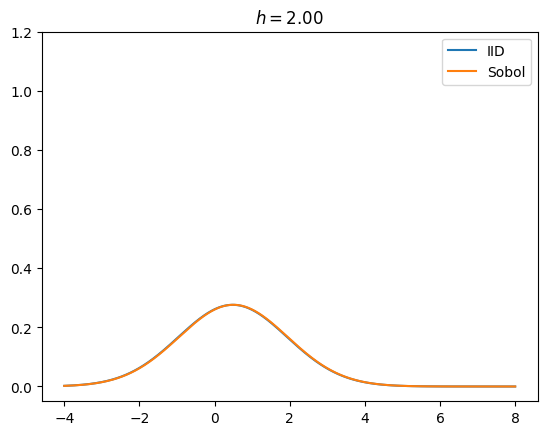

In [48]:
# dim = 1, fewer n = 2**10
bw = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
spaces = (-4, 8, 500)
generate_sobol_iid_graph(bw, spaces, kde, kernel, few_yiid_unif1, few_ysob_unif1)

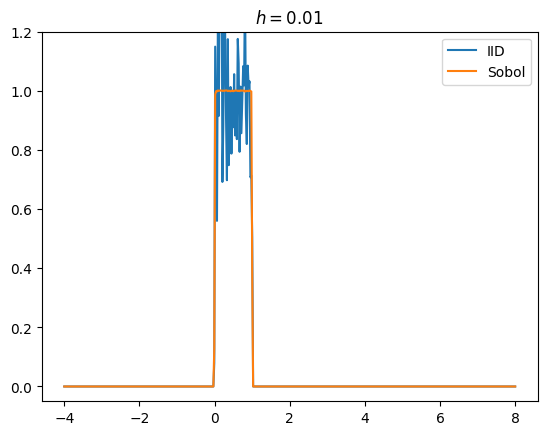

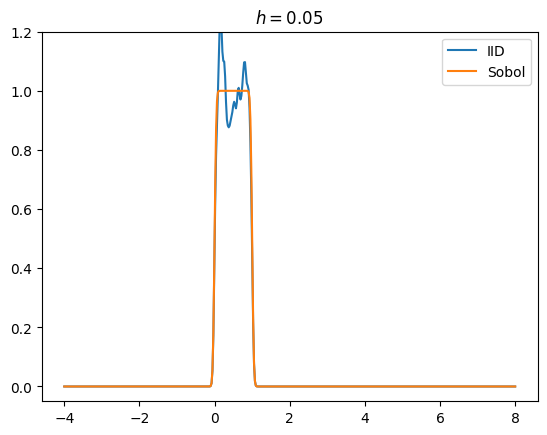

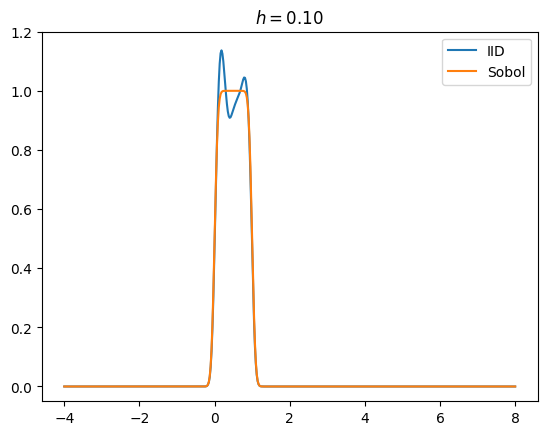

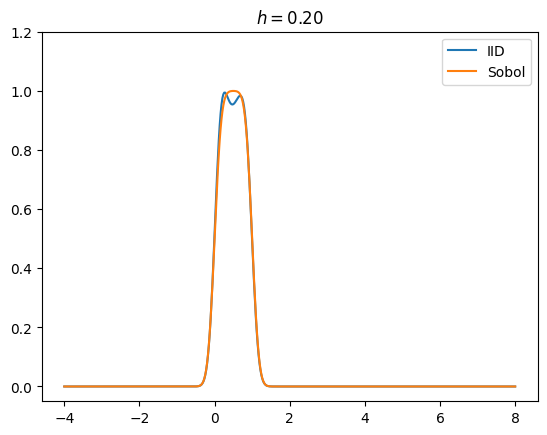

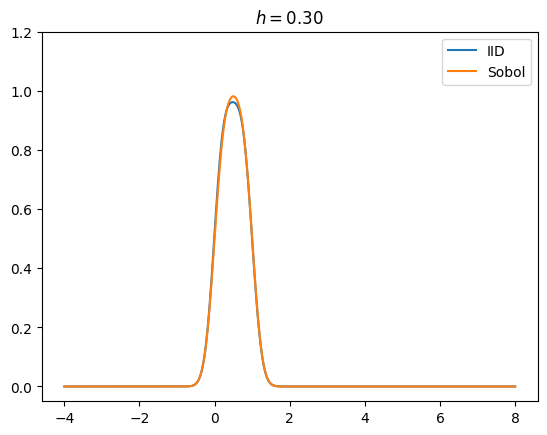

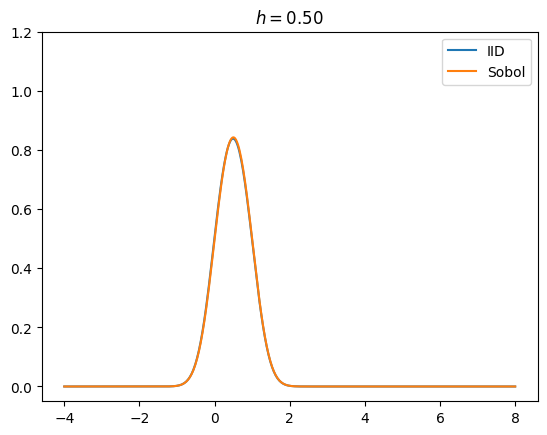

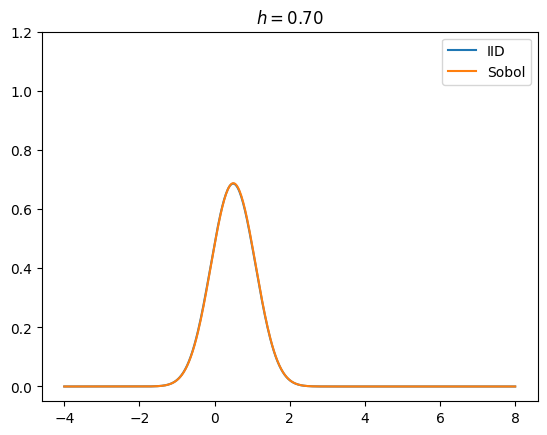

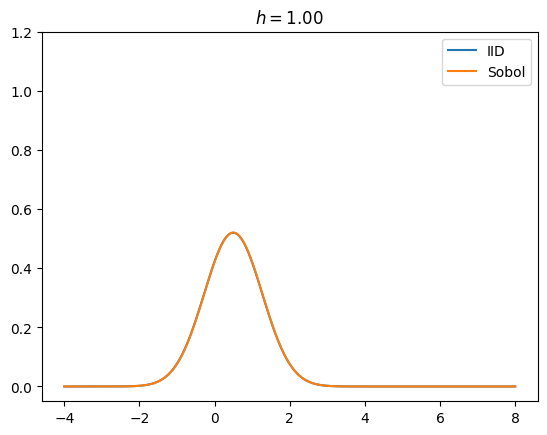

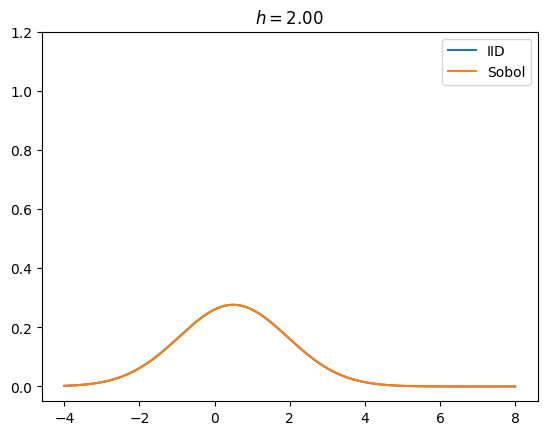

In [49]:
# dim = 3, fewer n = 2**10
bw = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
spaces = (-4, 8, 500)
generate_sobol_iid_graph(bw, spaces, kde, kernel, few_yiid_unif3, few_ysob_unif3)

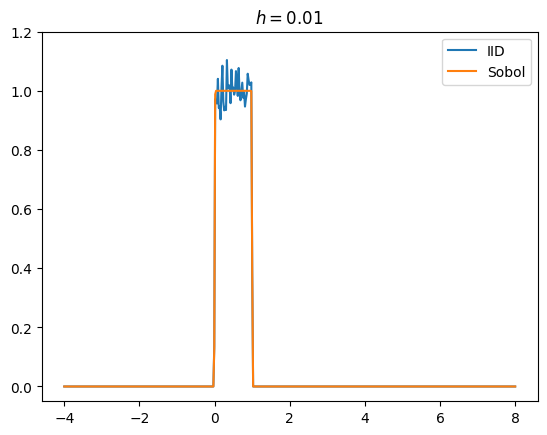

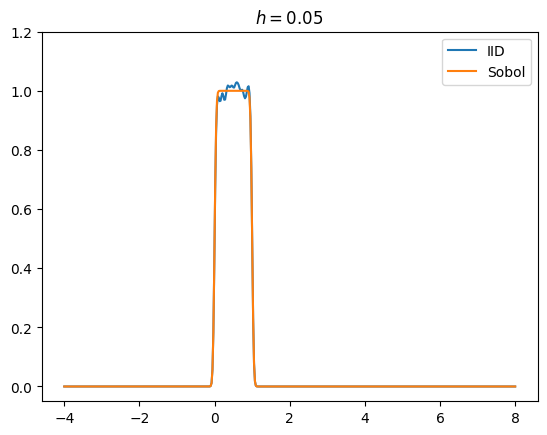

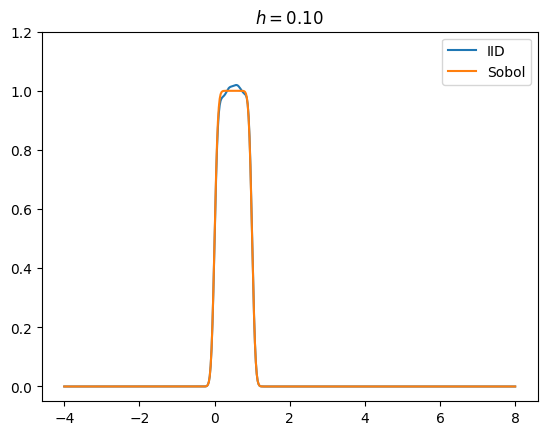

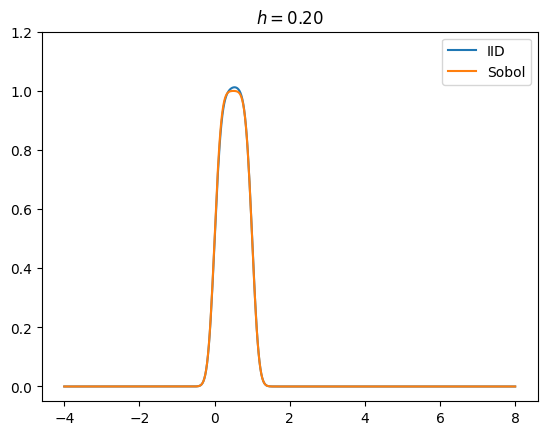

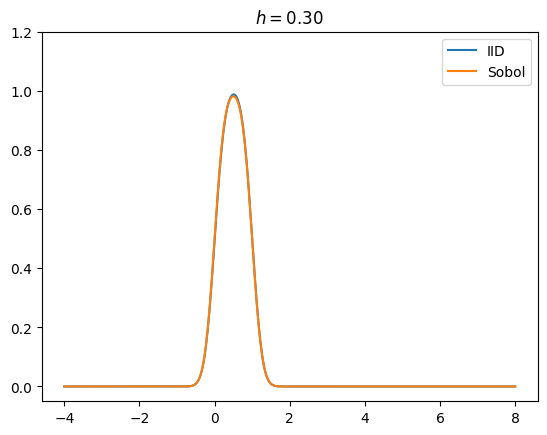

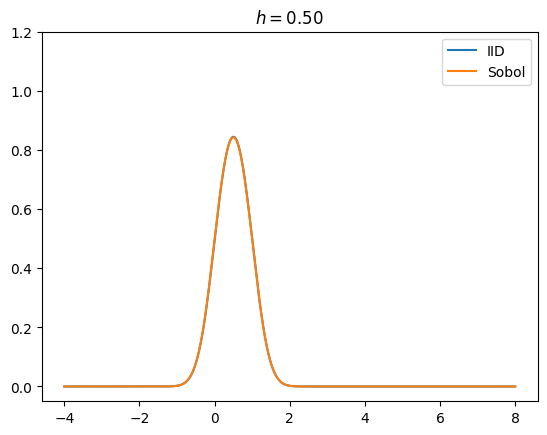

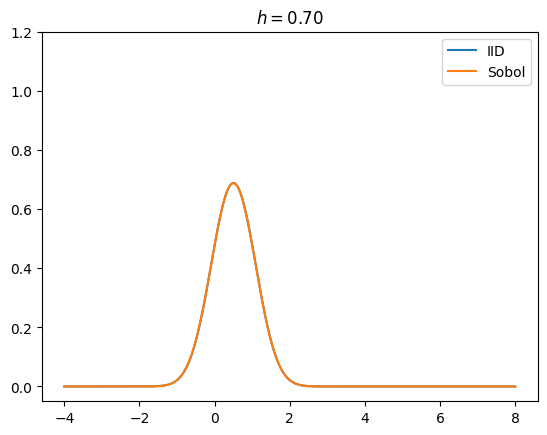

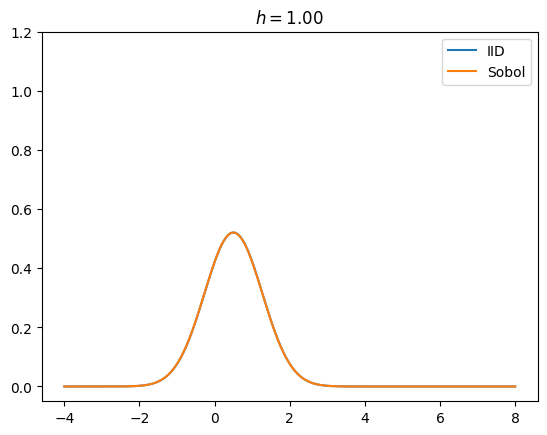

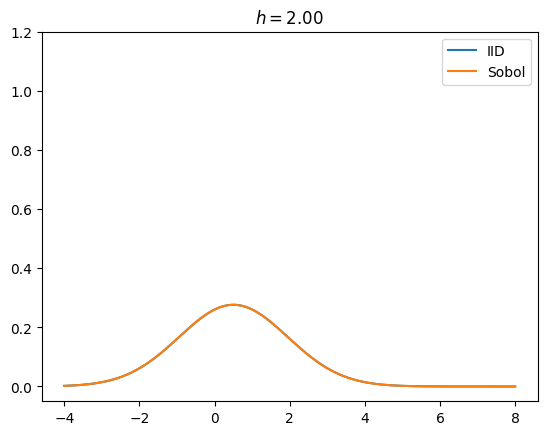

In [50]:
# dim = 1, more n = 2**14
bw = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
spaces = (-4, 8, 500)
generate_sobol_iid_graph(bw, spaces, kde, kernel, many_yiid_unif1, many_ysob_unif1)

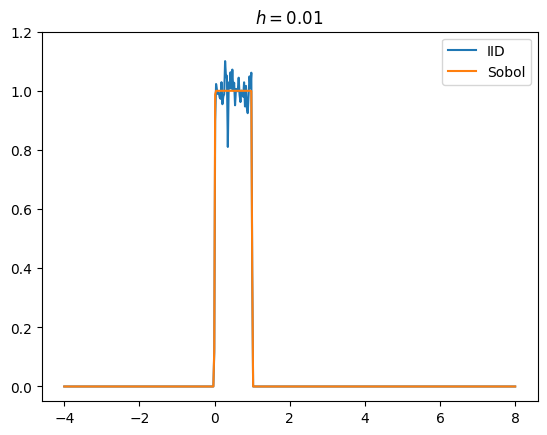

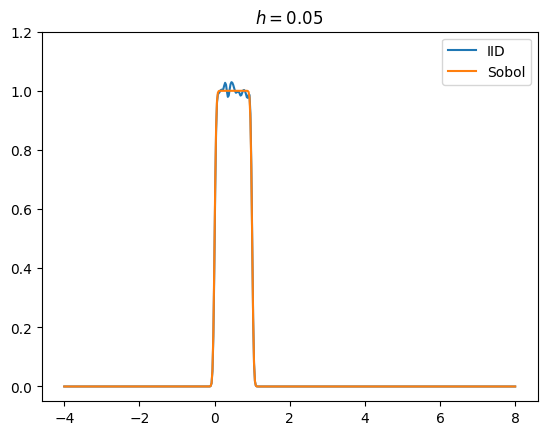

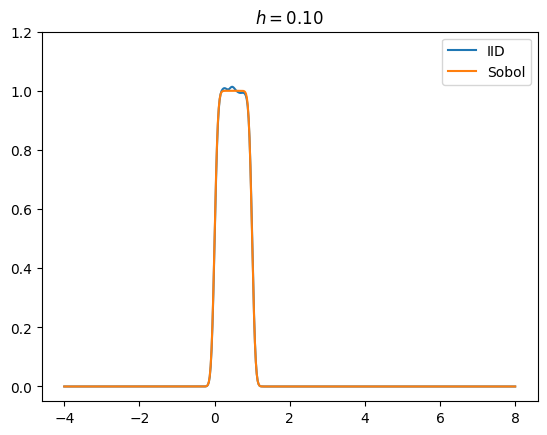

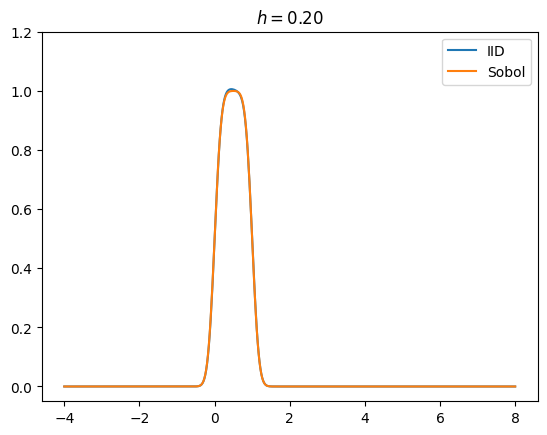

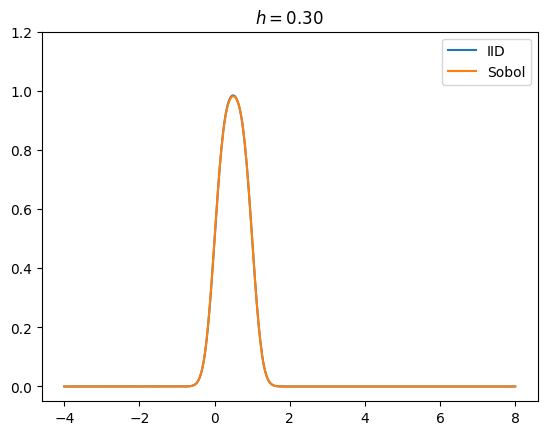

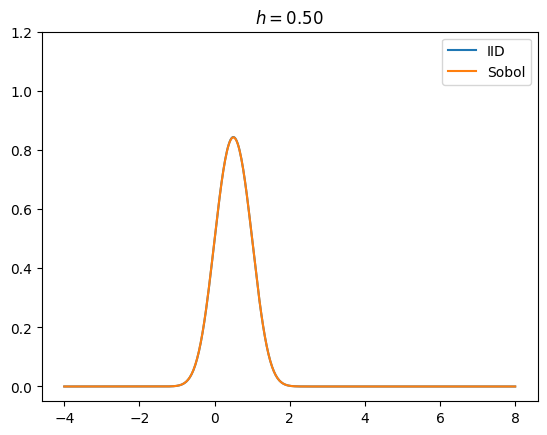

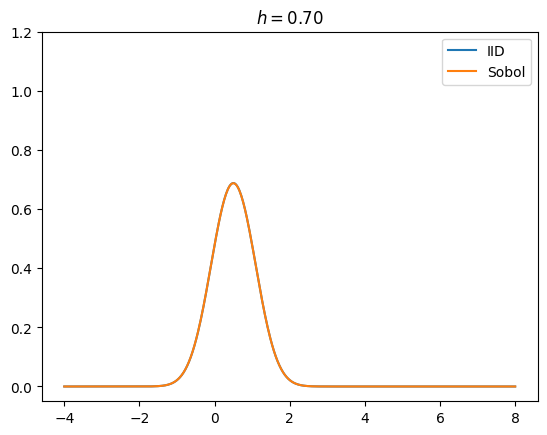

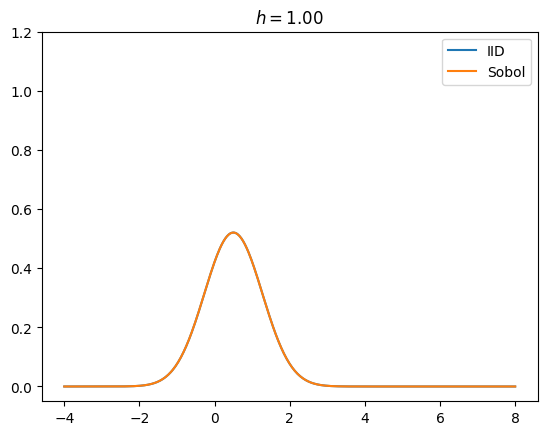

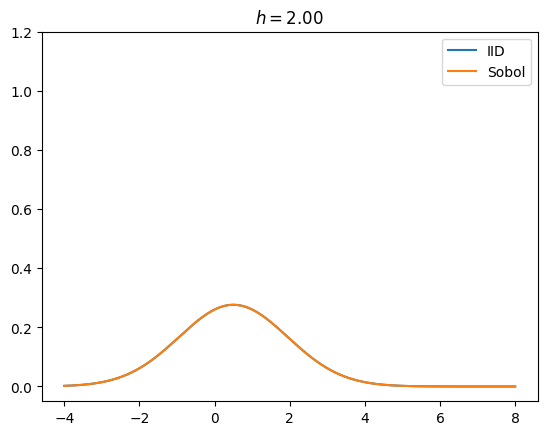

In [51]:
# dim = 3, more n = 2**14
bw = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
spaces = (-4, 8, 500)
generate_sobol_iid_graph(bw, spaces, kde, kernel, many_yiid_unif3, many_ysob_unif3)

# Testing different LD sequences: Sobol, Lattice, Digital Net B2, and Halton

In [53]:
# iidpts1, sobpts1, latticepts1, dnetb2pts1, haltonpts1 = gen_iid_ld_pts()
points1 = gen_iid_ld_pts(dimen = 1, n = 2**12) # dim = 1
points3 = gen_iid_ld_pts(dimen = 3, n = 2**12) # dim = 3

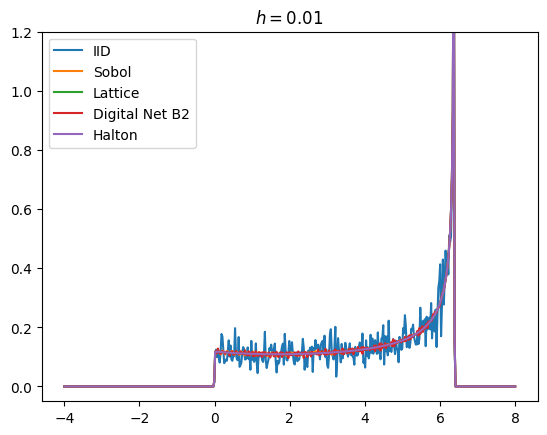

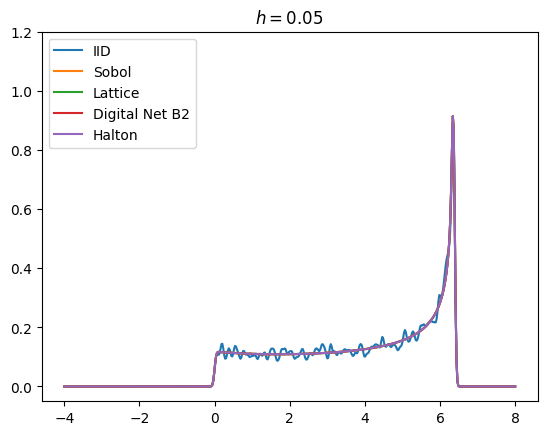

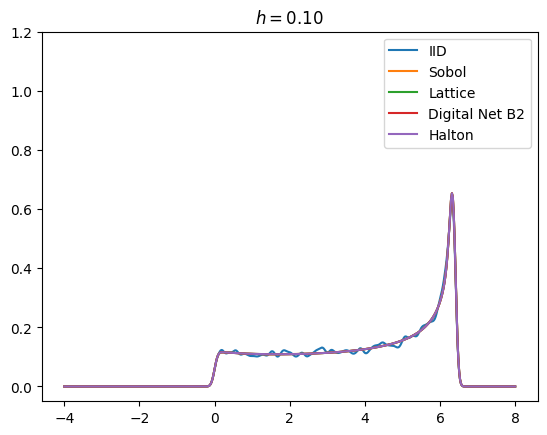

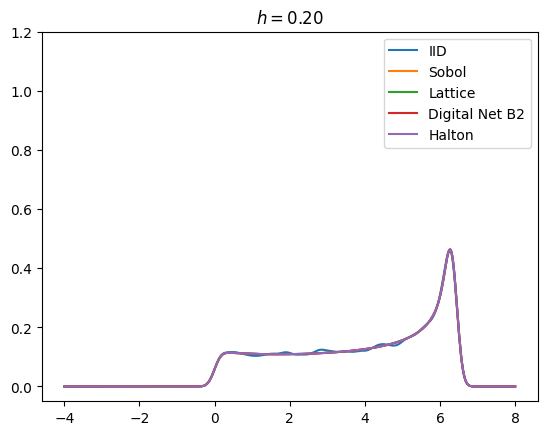

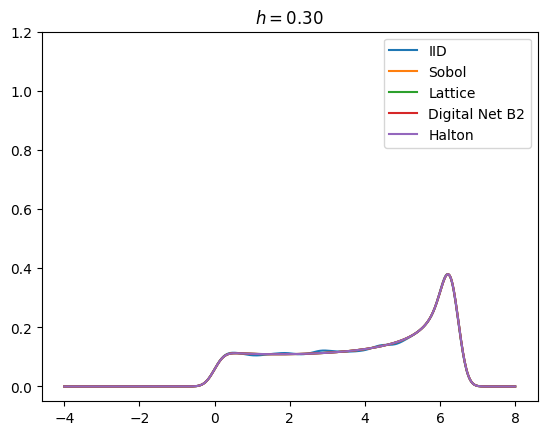

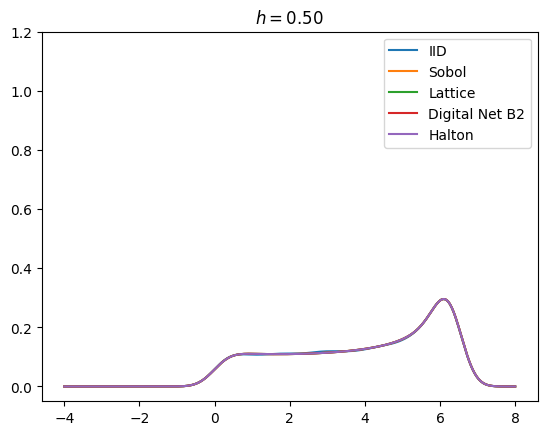

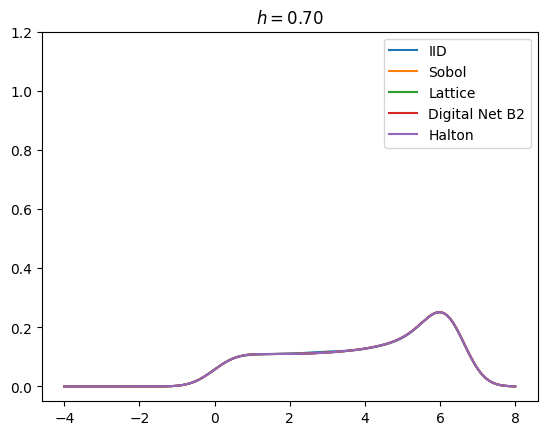

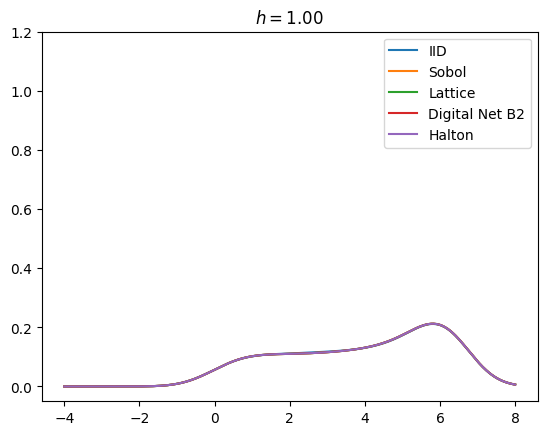

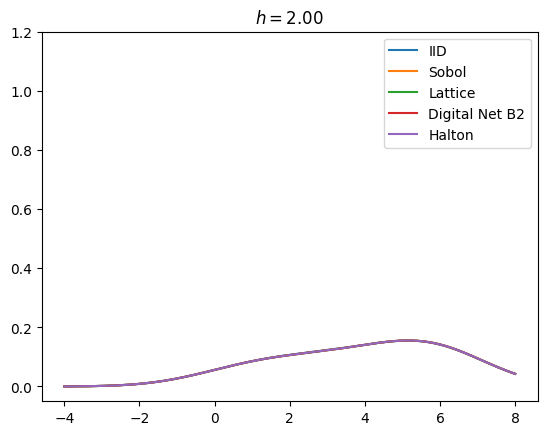

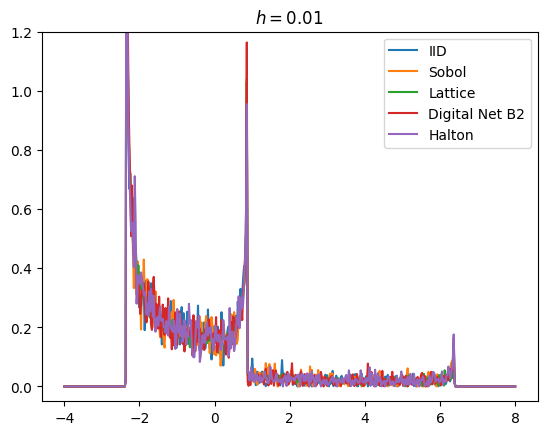

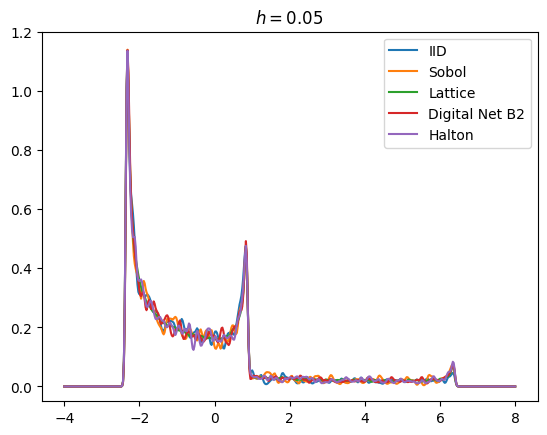

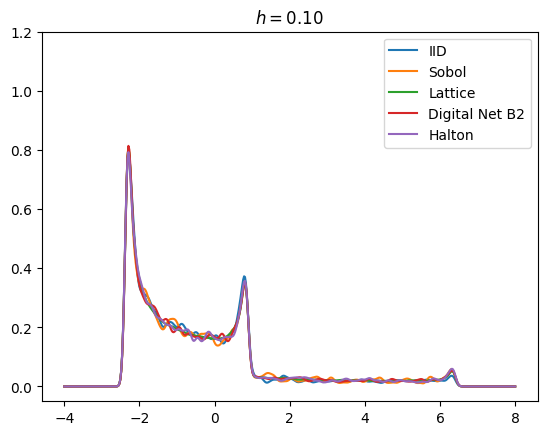

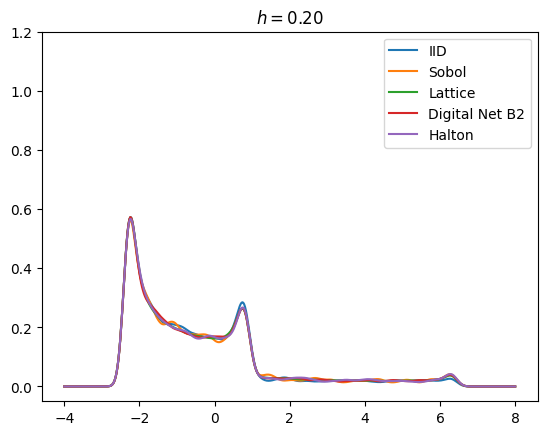

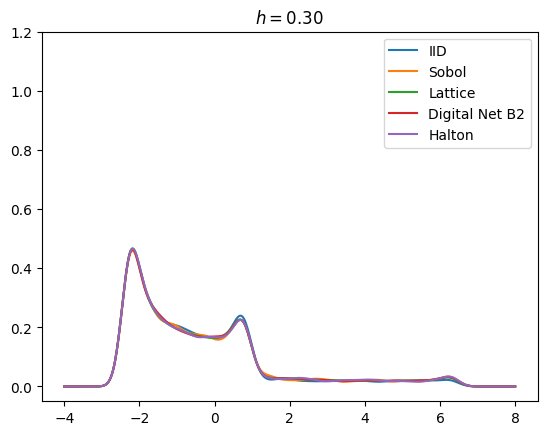

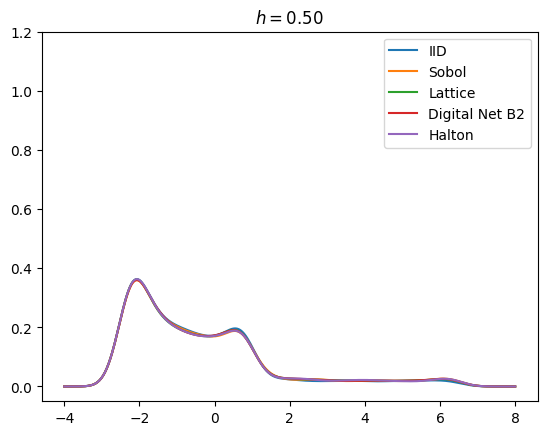

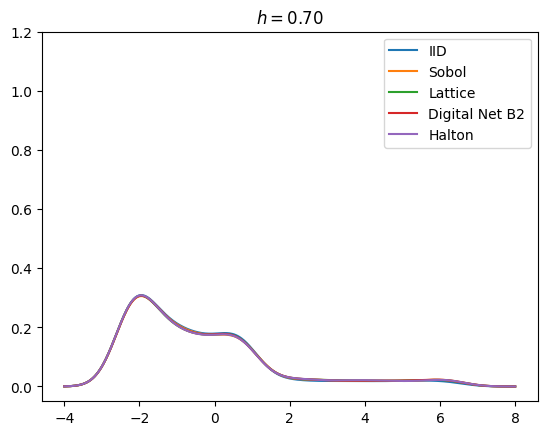

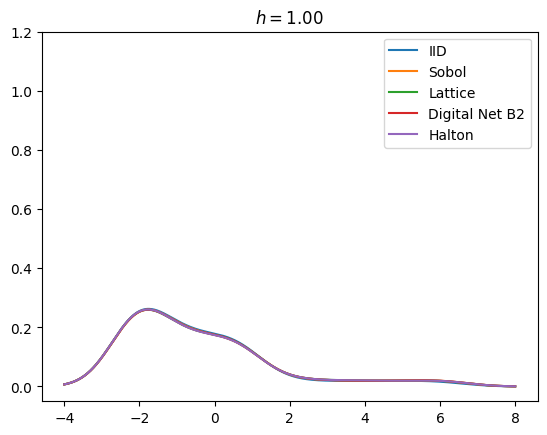

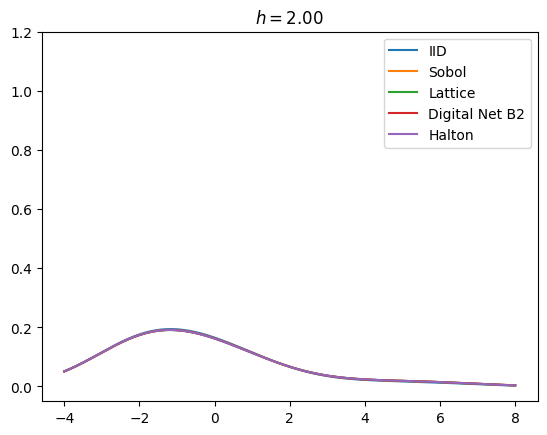

In [55]:
# using original function f(x)

lst_points1 = list()
lst_points3 = list()

for pts in points1:
  lst_points1.append(testfun1(pts))

for pts in points3:
  lst_points3.append(testfun1(pts))

bw = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
spaces = (-4, 8, 500)
generate_graphs(bw, spaces, kde, kernel, lst_points1)
generate_graphs(bw, spaces, kde, kernel, lst_points3)

# Testing Different Kernels

The following Python function definition is the expression:

$$
y=\begin{cases}
            \frac{\pi}{4}\cos\left(\frac{\pi}{2} y\right), & |y| \leq 1\\
            0, & Otherwise
        \end{cases}
$$

In [57]:
# cosine--has best performance according to paper?
def kernel_cos(y):
    return np.heaviside(1-np.absolute(y), 1/2)*(math.pi/4)*np.cos((math.pi/2)*y)

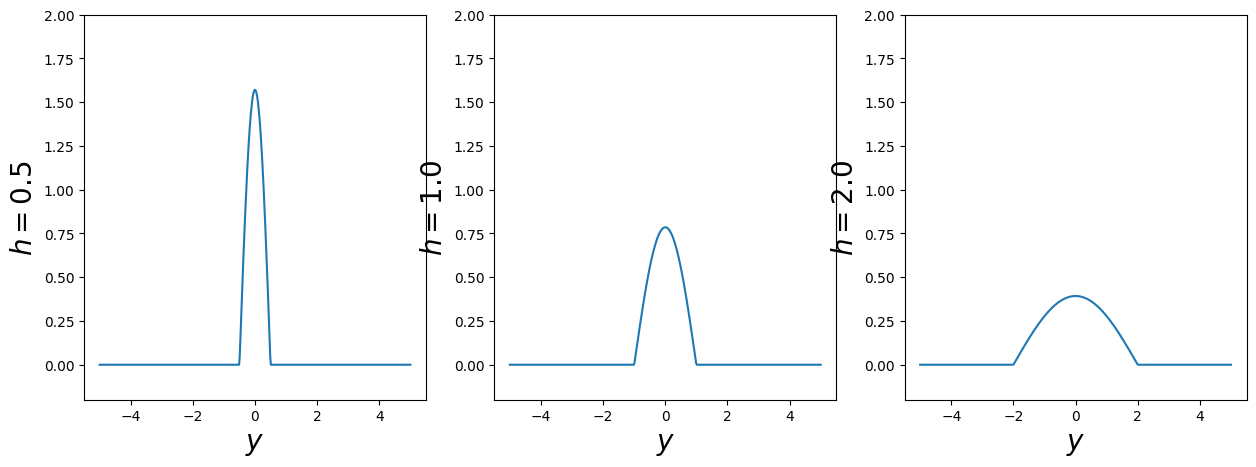

In [59]:
graph_kernel([0.5, 1, 2], (-5, 5, 500), kernel_cos, ylim_lst = [-0.2, 2])

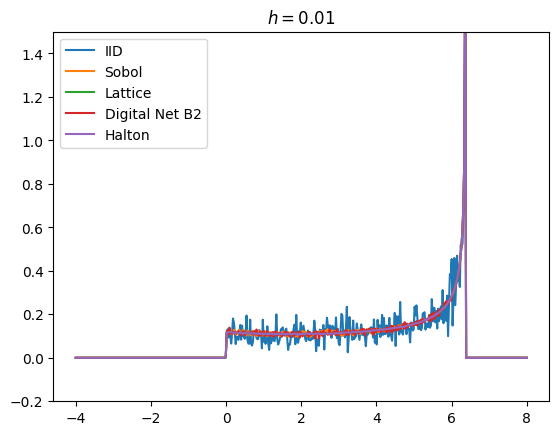

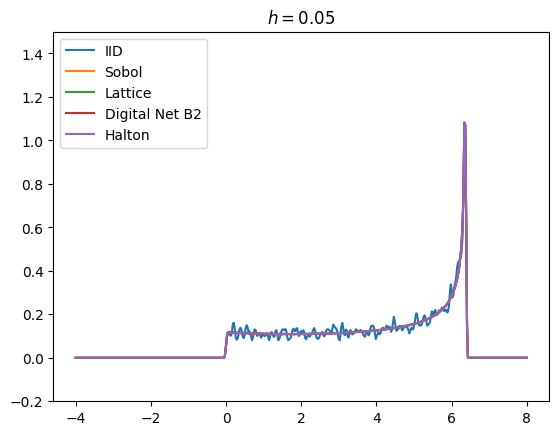

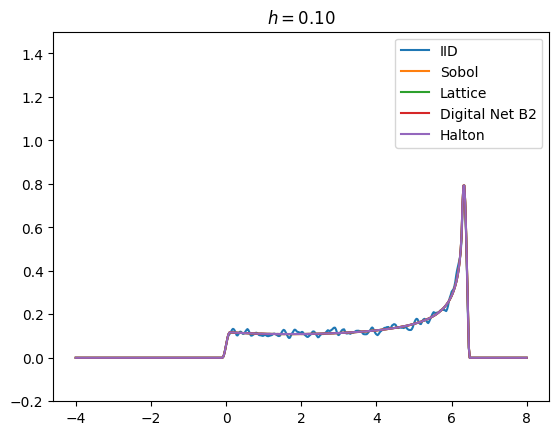

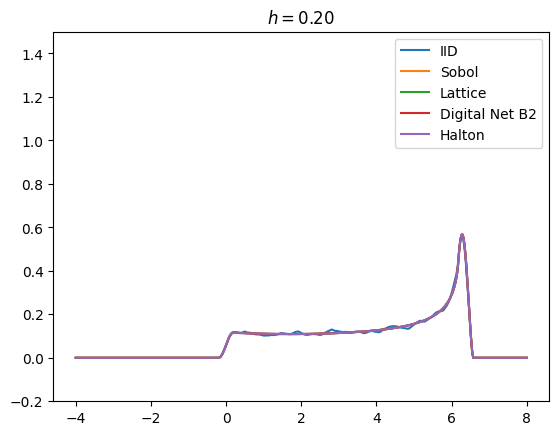

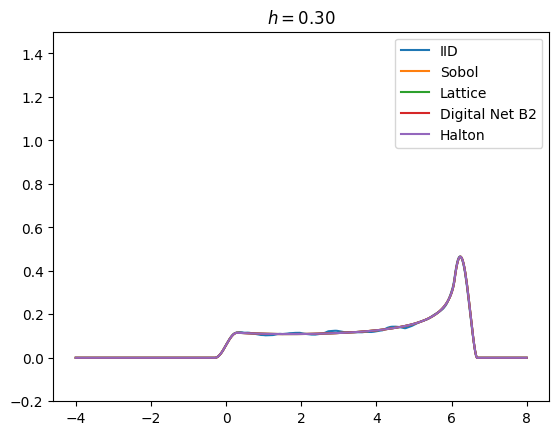

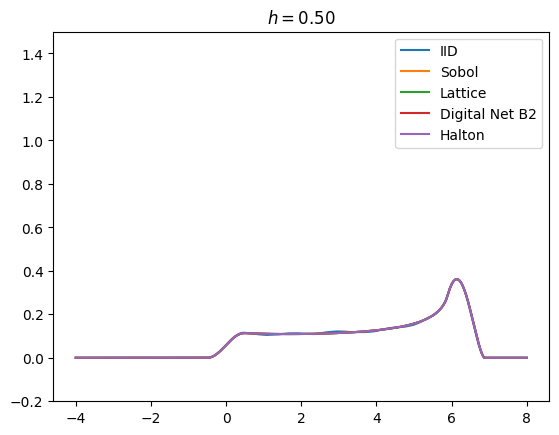

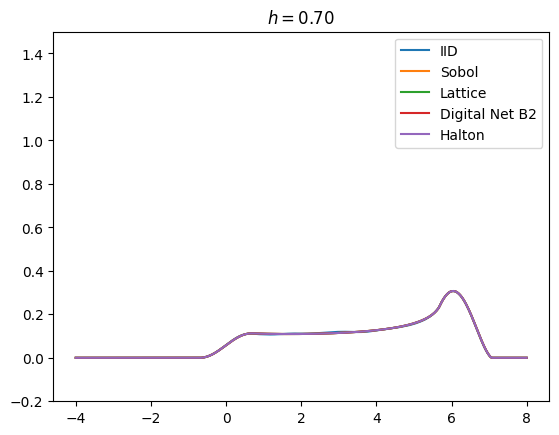

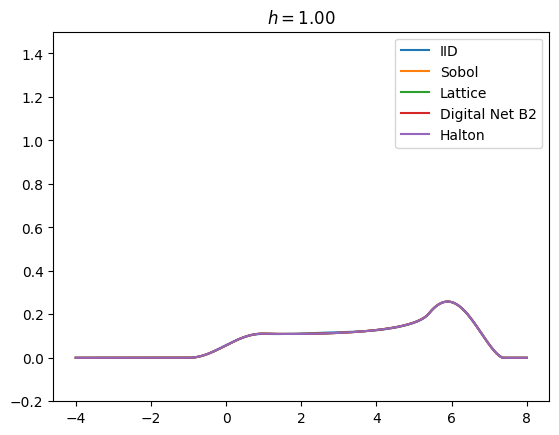

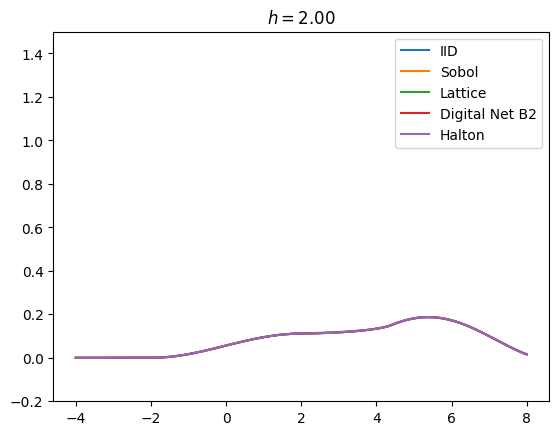

In [61]:
# dim = 1
bw = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
spaces = (-4, 8, 500)
generate_graphs(bw, spaces, kde, kernel_cos, lst_points1, ylim_lst = [-0.2, 1.5])

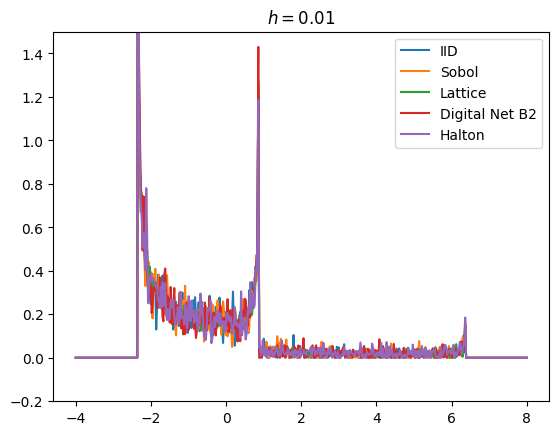

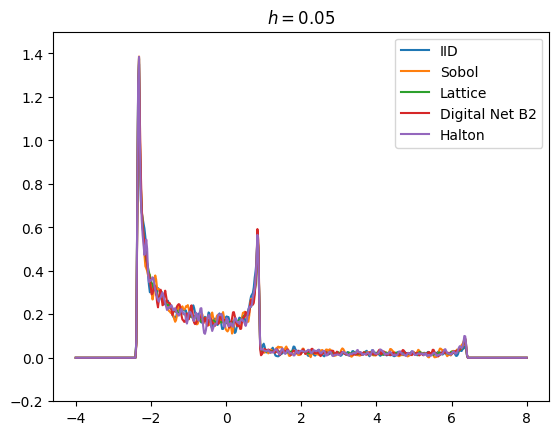

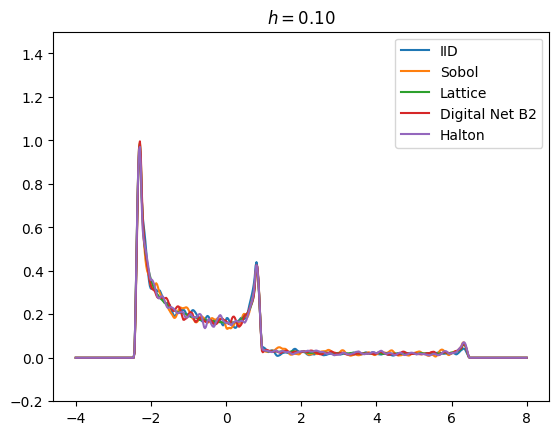

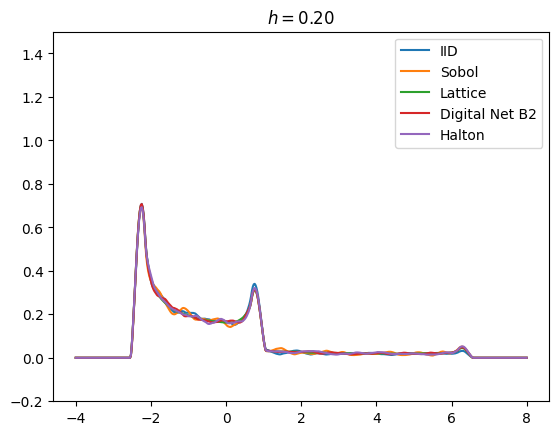

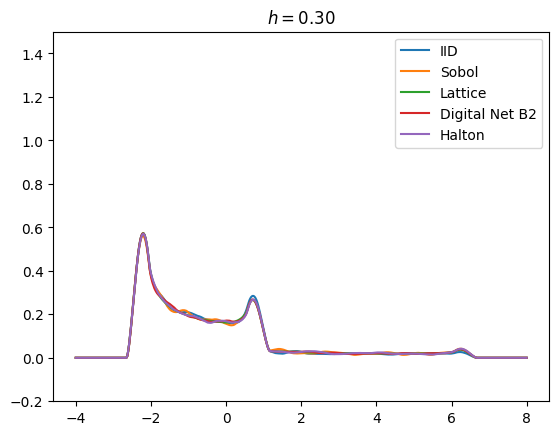

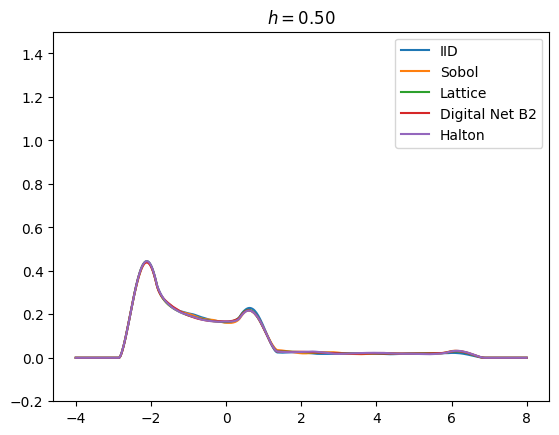

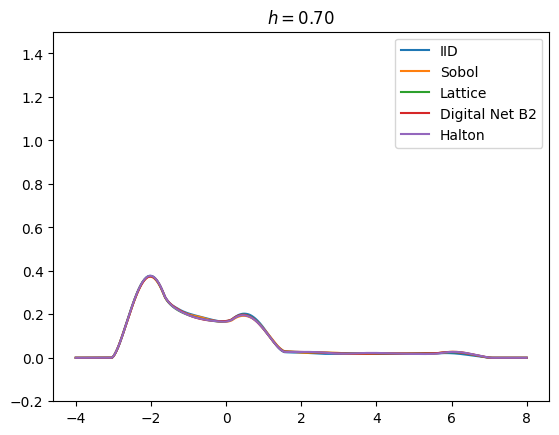

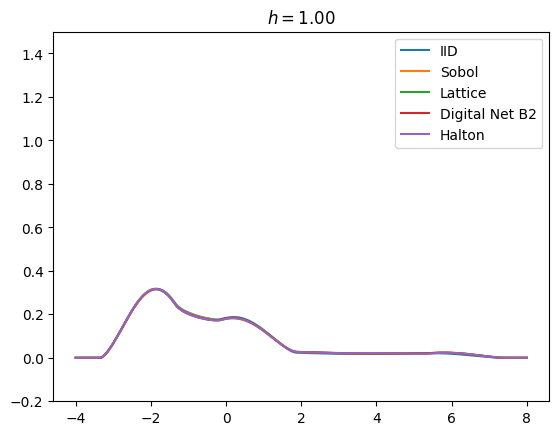

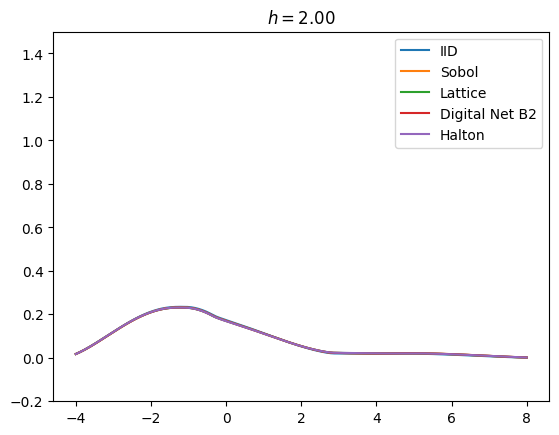

In [62]:
# dim = 3
bw = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
spaces = (-4, 8, 500)
generate_graphs(bw, spaces, kde, kernel_cos, lst_points3, ylim_lst = [-0.2, 1.5])

The following Python function defines the kernel:

$$
y=\begin{cases}
            1 - |y|, & |y| \leq 1\\
            0, & Otherwise
        \end{cases}
$$

In [64]:
# triangular kernel
def kernel_tri(y):
    return np.heaviside(1-np.absolute(y), 1/2)*(1 - np.absolute(y))

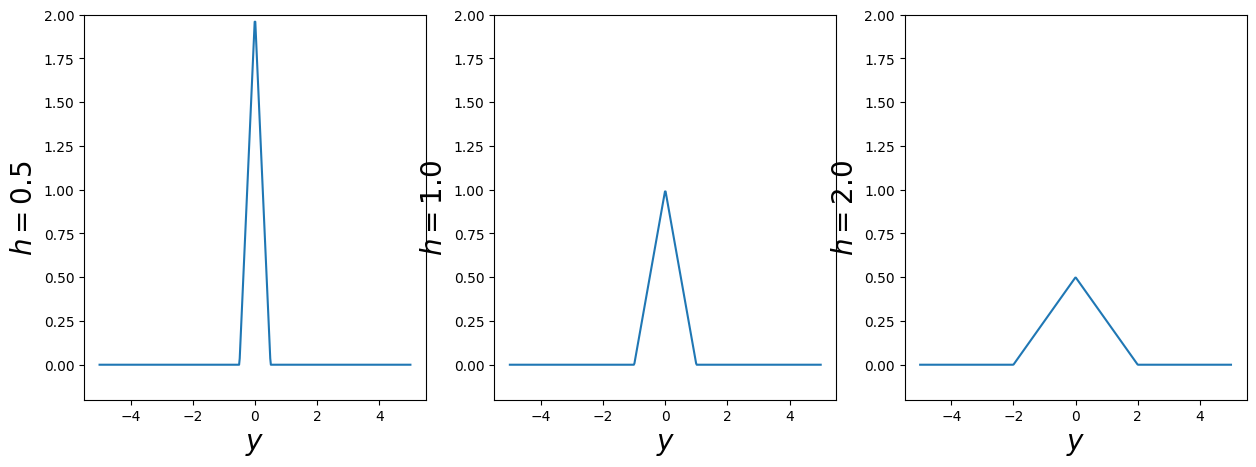

In [65]:
graph_kernel([0.5, 1, 2], (-5, 5, 500), kernel_tri, ylim_lst = [-0.2, 2])

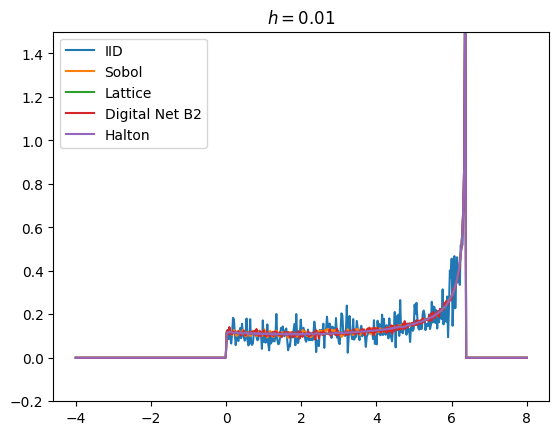

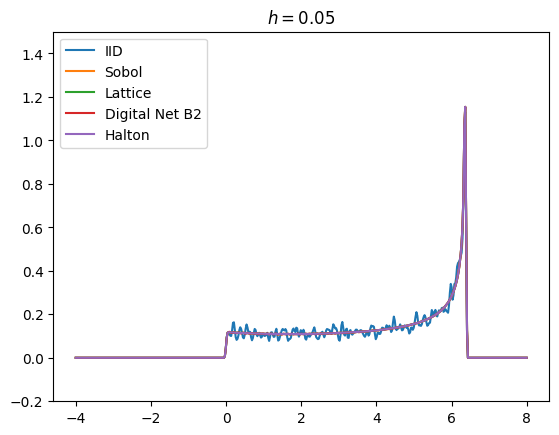

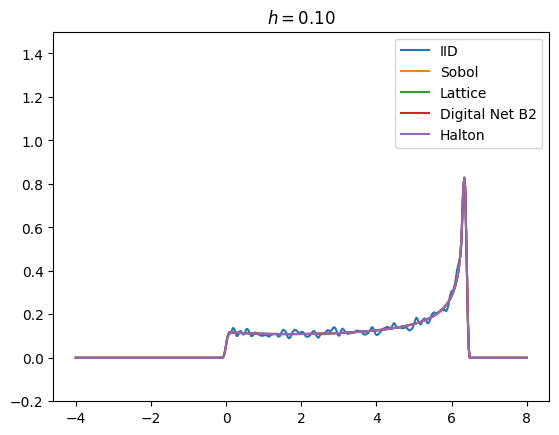

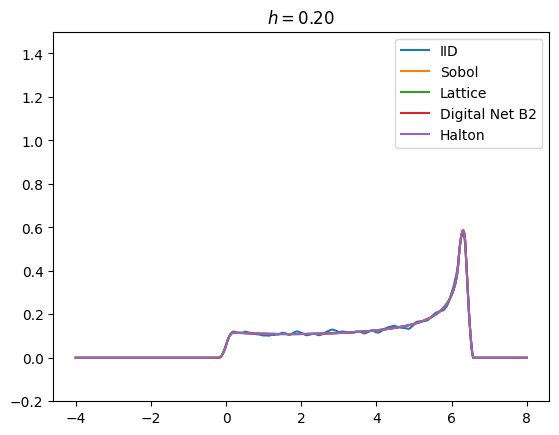

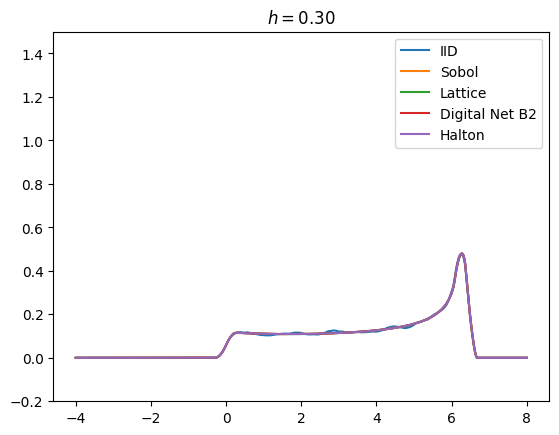

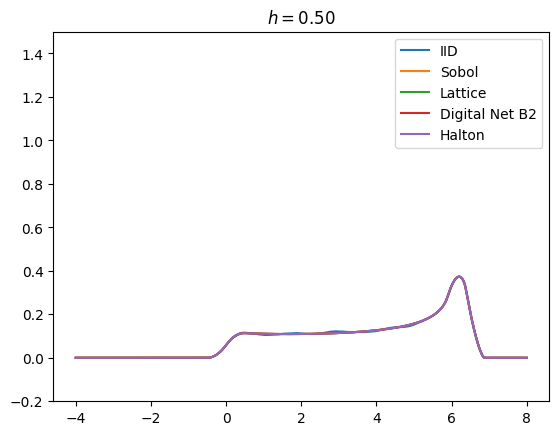

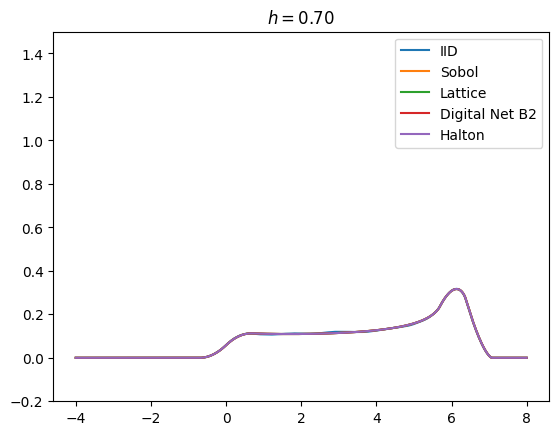

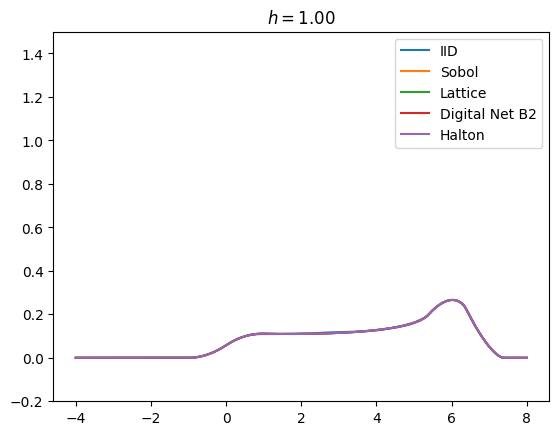

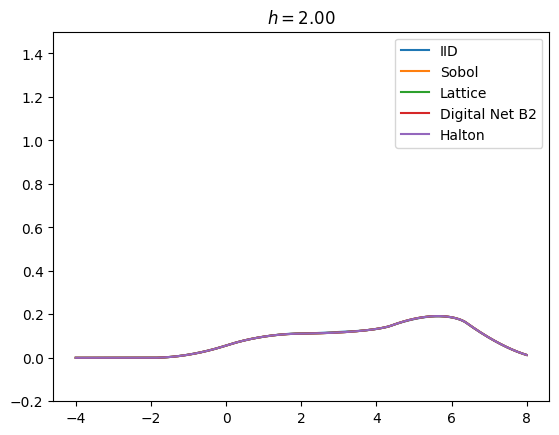

In [66]:
# dim = 1
bw = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
spaces = (-4, 8, 500)
generate_graphs(bw, spaces, kde, kernel_tri, lst_points1, ylim_lst = [-0.2, 1.5])

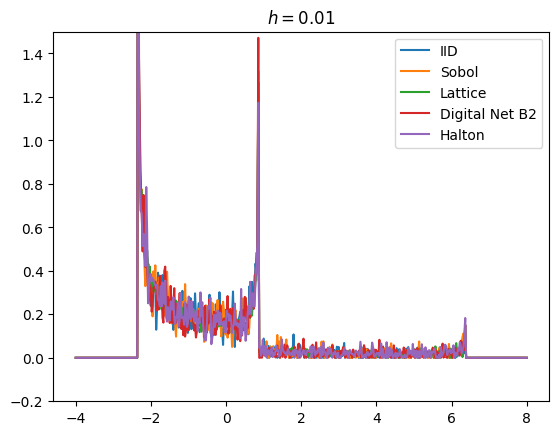

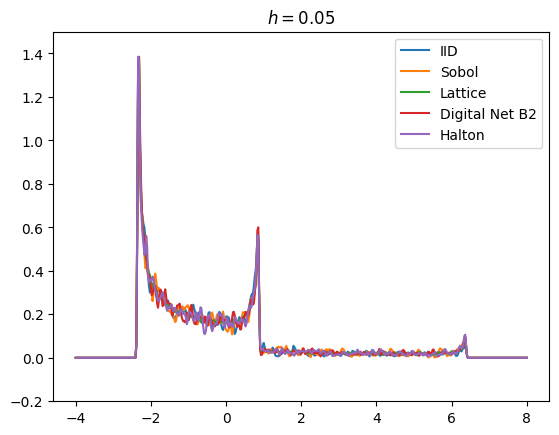

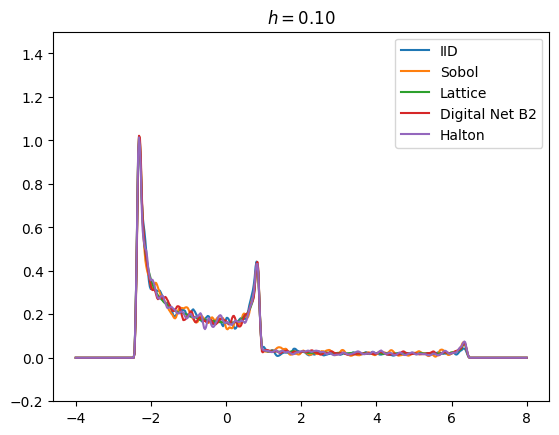

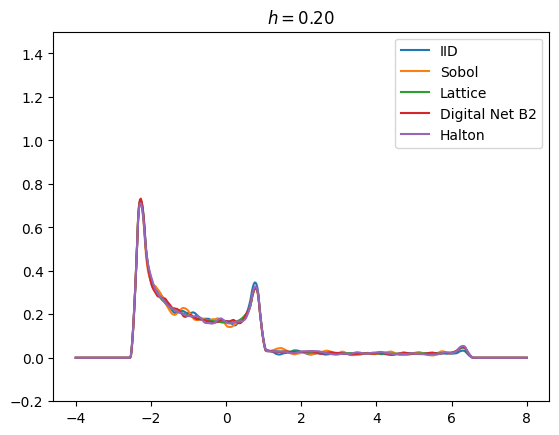

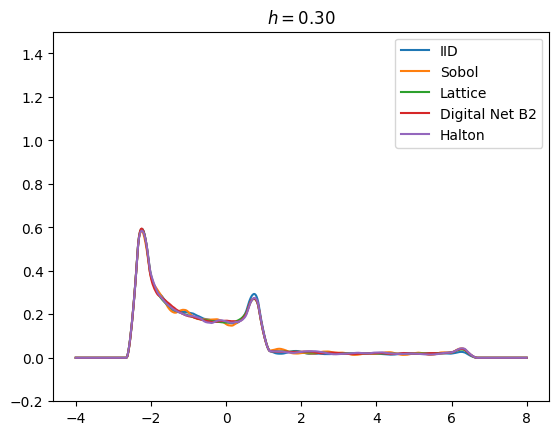

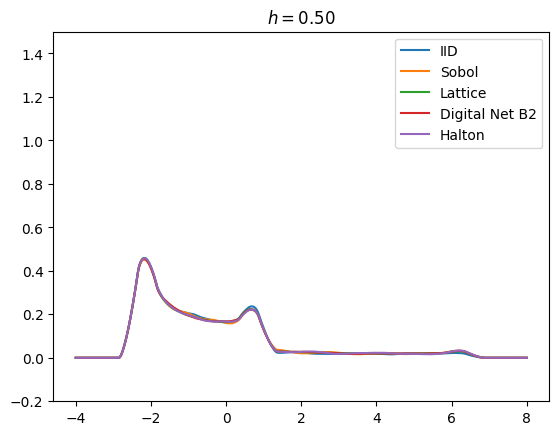

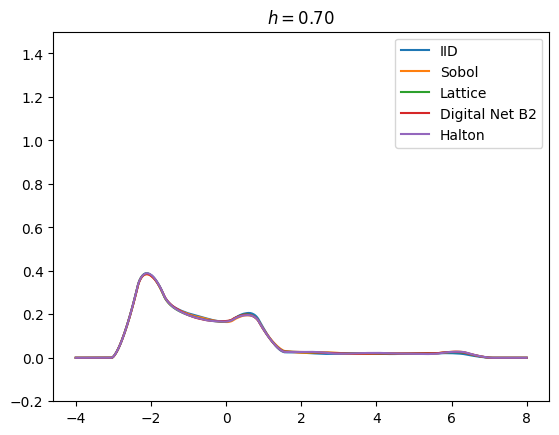

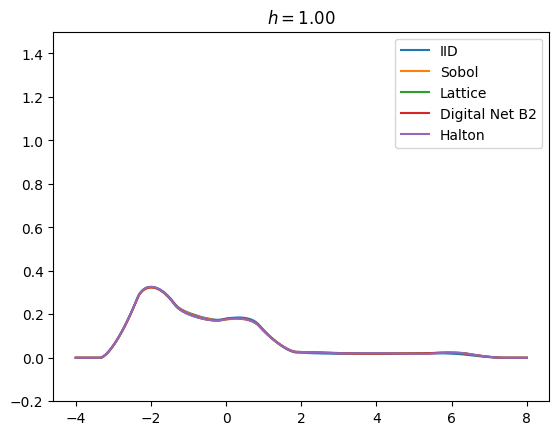

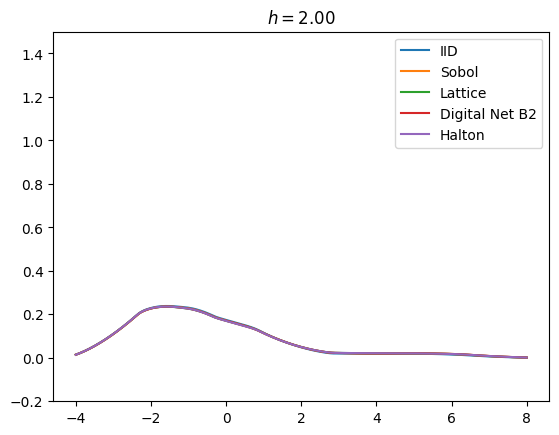

In [67]:
# dim = 3
bw = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
spaces = (-4, 8, 500)
generate_graphs(bw, spaces, kde, kernel_tri, lst_points3, ylim_lst = [-0.2, 1.5])

The following Python function defines the kernel:

$$
y=\begin{cases}
            \frac{1}{\pi} (1-\frac{y^2}{2}) e^-(\frac{y^2}{2}), & |y| \leq 1\\
            0, & Otherwise
        \end{cases}
$$

In [68]:
# laplacian of Gaussian--performed poorly according to paper
def kernel_laog(y):
    return np.heaviside(1-np.absolute(y), 1/2)*((1/math.pi)*(1-(y**2)/2)*np.exp(-(y**2)/2))

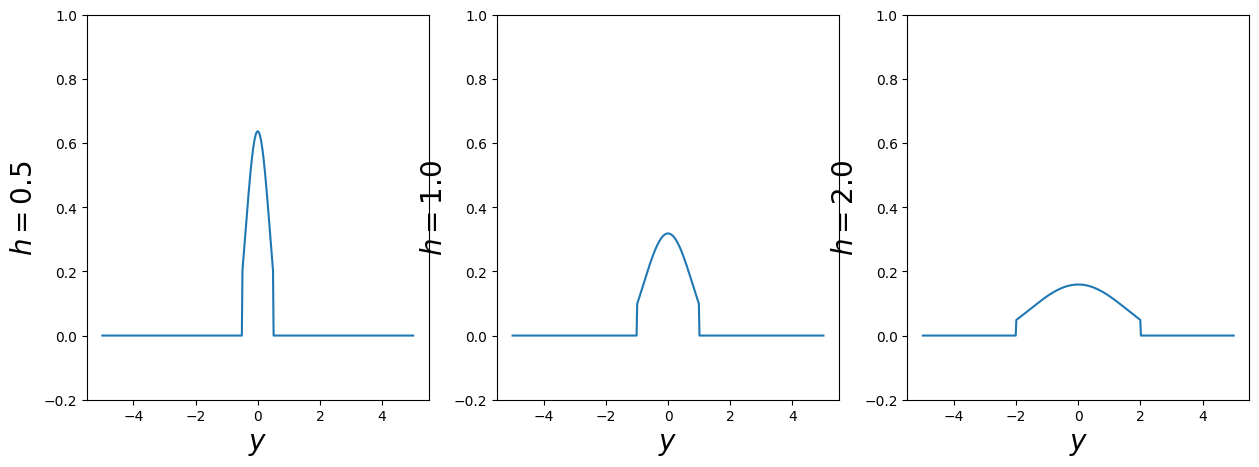

In [70]:
graph_kernel([0.5, 1, 2], (-5, 5, 500), kernel_laog, ylim_lst = [-0.2, 1])

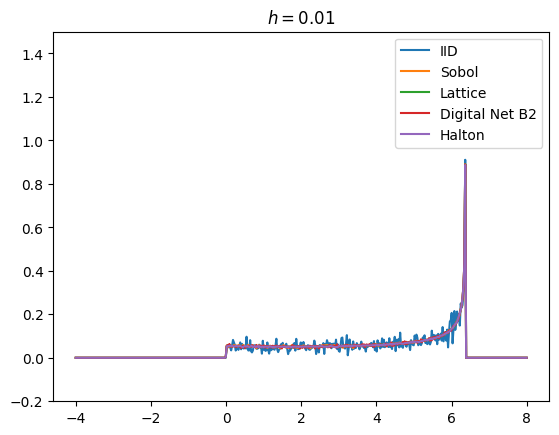

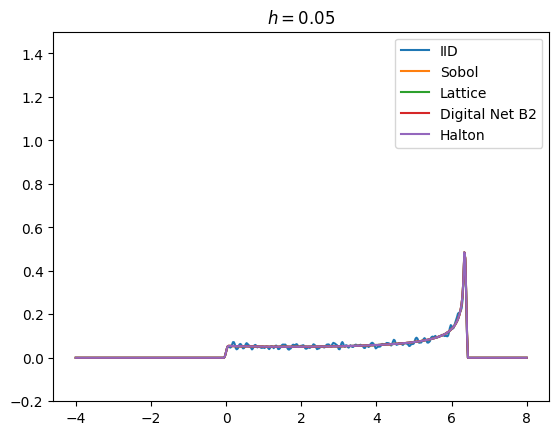

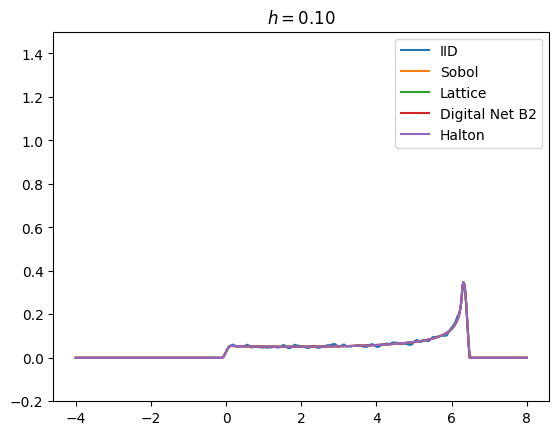

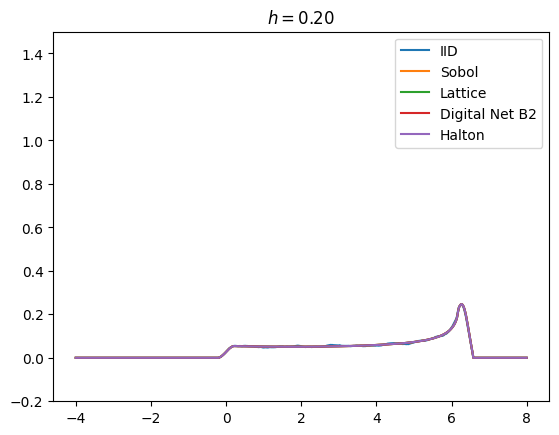

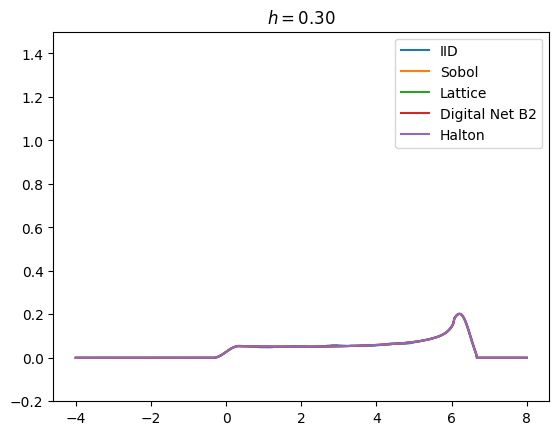

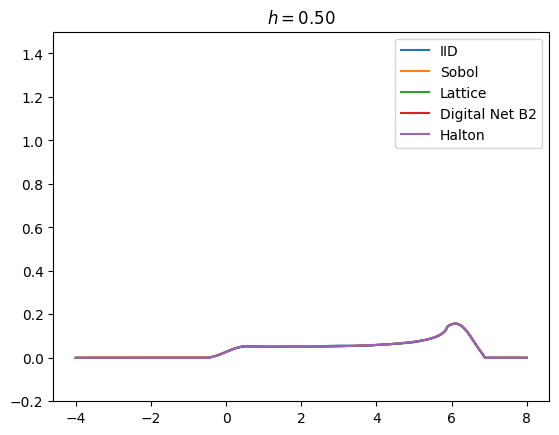

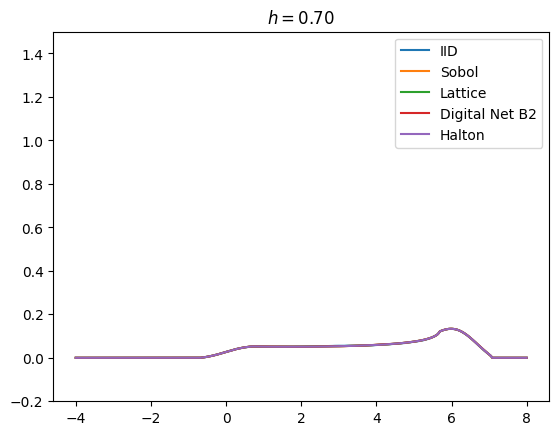

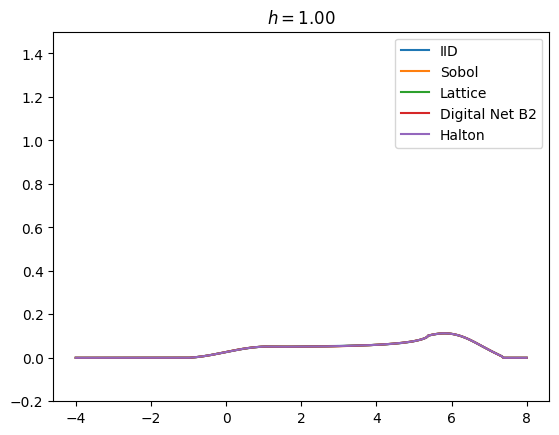

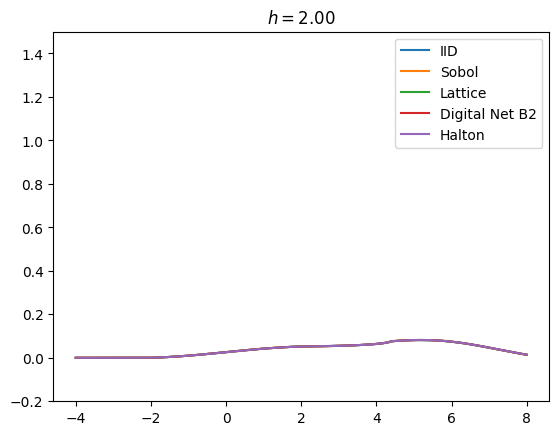

In [71]:
# dim = 1
bw = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
spaces = (-4, 8, 500)
generate_graphs(bw, spaces, kde, kernel_laog, lst_points1, ylim_lst = [-0.2, 1.5])

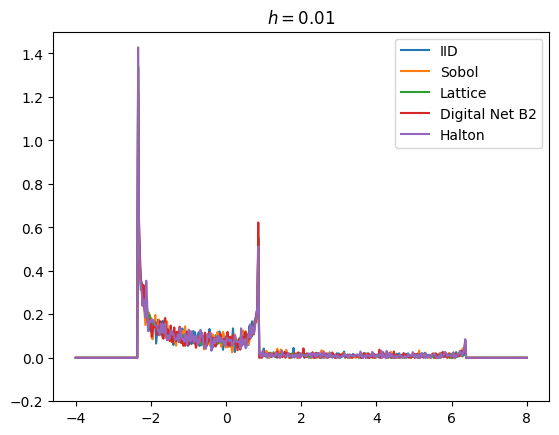

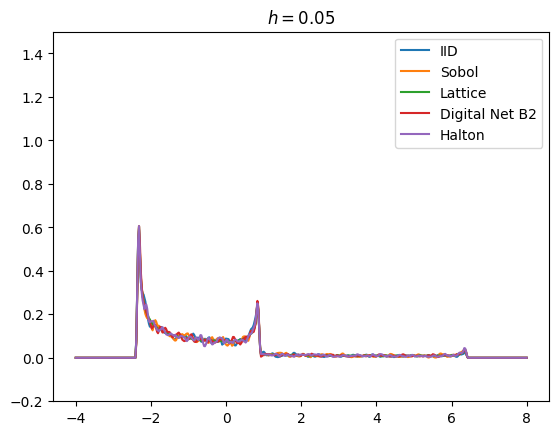

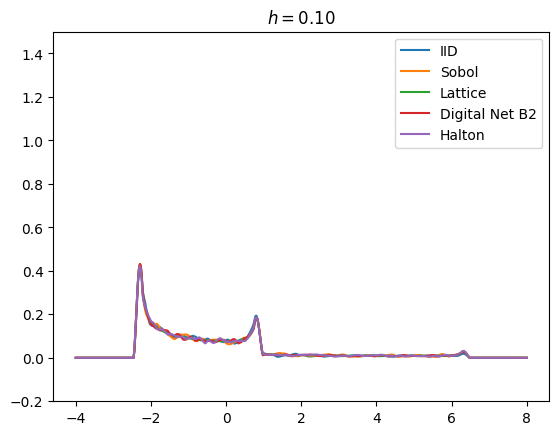

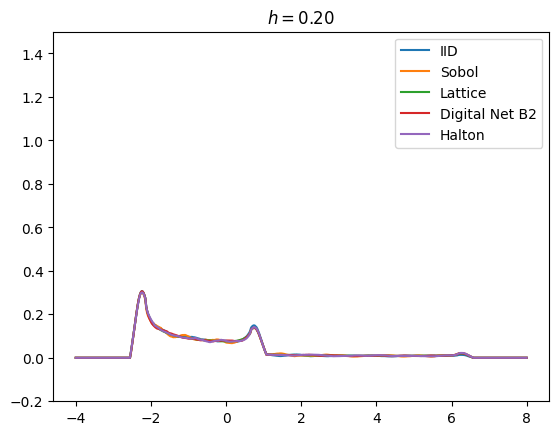

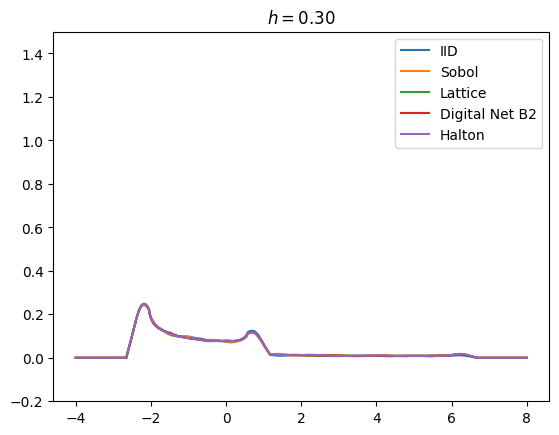

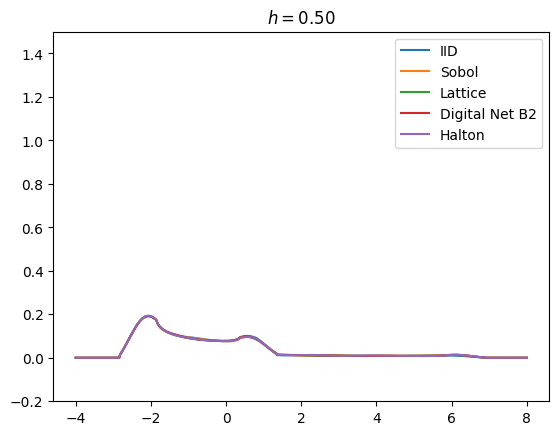

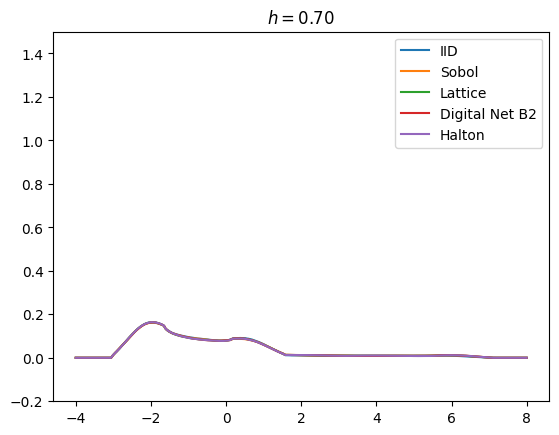

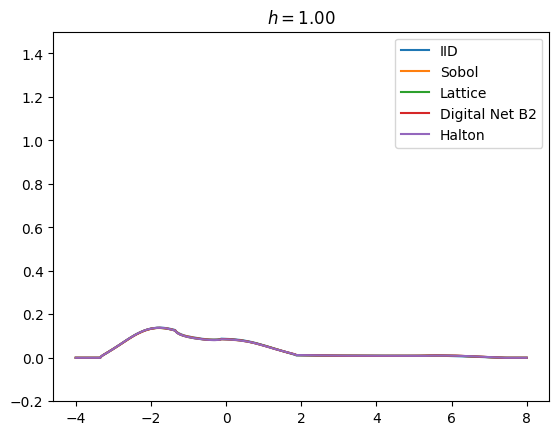

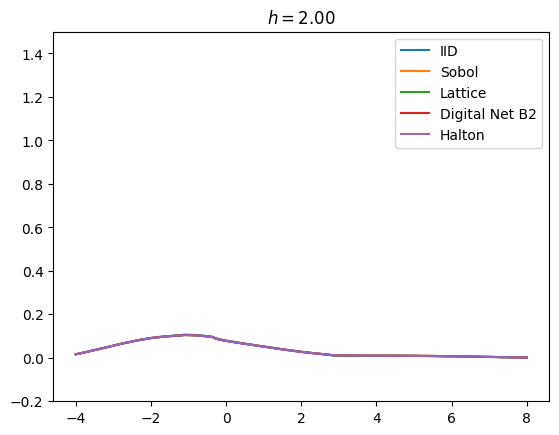

In [72]:
# dim = 3
bw = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
spaces = (-4, 8, 500)
generate_graphs(bw, spaces, kde, kernel_laog, lst_points3, ylim_lst = [-0.2, 1.5])

## Hermite Kernel

The following comes from Dr. Hcikernell's KDE experiment notebook.


# Appendix

## Todo

This section must remain at the end of the notebook. These are a list of todos that are need to be done in the notebook or research tasks. When a task is done, use double `~~` to cross it out. Example \~\~crossed out text\~\~; output: ~~crossed out text~~.

- Change `graph_kernel`, `generate_sobol_iid_graph`, and `generate_graphs` arguement `ylim_lst` such that it has a default that makes sense.
- Some functions need better docstrings that are more detailed and follow PEP 257.
- `graph_kernel()` has some things in the images that shouldn't be there, such as a kernel that's not related to the kernel being graphed on the side. Fix this such that it doesn't appear or it show the correct kernel.